# Response Clustering

1. [Mooc tags dataset](#1)  
   1.1 [Word2Vec](#1.1)  
   1.2 [Fasttext](#1.2)  
   1.3 [Visualization](#1.3)   
2. [Reflection questions dataset](#2)  
   2.1 [Processing data](#2.1)   
   2.2 [Perform LDA and NMF](#2.2)  
   2.3 [Fasttext + Ontology + LDA](#2.3)  
   2.4 [Latent Semantic Analysis](#2.4)  
   2.4 [K means](#2.5)  
3. [Put all things together](#3)  
   3.1 [Dashboard](#3.1)   
   3.2 [Detecting concepts + Create student groups](#3.2)  

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
import time
import requests
import csv
import json
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from collections import OrderedDict

In [52]:
from concept import *
from helpers import *
from lsa import *
from ontology import *
#from responses_processing import *
#from tags_processing import *
#from topic_modelling import *
from visualization import *
from preprocessing import *
from french_prerpocessing import *
#from dashboard import *

In [4]:
warnings.filterwarnings('ignore')

In [5]:
def set_size(SIZE=20):
    """
     This method sets size for labels, legends... of matplotlib.pyplot
    """

    plt.rc('font', size=SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE)    # legend fontsize
    plt.rc('figure', titlesize=SIZE)

In [6]:
SEED = 9016891

# 1) Mooc tags dataset
<a id='1'></a>


In [6]:
mooc_tags = pd.read_csv("data/mooc_tags.txt" ,delimiter="\t")
mooc_tags.columns = ['text']
mooc_tags.head(10)

text
0                        area
1               living things
2  plants: growth and changes
3  animals: growth and change
4                  structures
5      american music history
6                        soil
7                          pe
8                    anathomy
9              best practices

In [7]:
mooc_tags.describe()

text
count    2096
unique   2094
top     tesol
freq        2

There are 2096 tags in the database

First, depend on the dataset and on the purpose, we decide what to be removed.
Need to see some samples in the dataset and try to detect some special things to be removed.
For instant, we remove urls, hashtag, @, numbers, punctuations.

In [8]:
mooc_tags = standardize_tags(mooc_tags, "text")
mooc_tags.head(10)

text           standardized_text
0                        area                        area
1               living things               living things
2  plants: growth and changes  plants  growth and changes
3  animals: growth and change  animals  growth and change
4                  structures                  structures
5      american music history      american music history
6                        soil                        soil
7                          pe                          pe
8                    anathomy                    anathomy
9              best practices              best practices

Secondly, we need to choose `indexing terms` for our TFIDF matrix. Step by step:
* Tokenization: splitting the text into words (actually a NLP issue, think about `credit card`...)
* Stopwords removing: term explicitely to be excluded from indexing (the, a, be, this, to, or...). What happened if we have a text `to be or not to be` ?
* Lemmatization: process of reducing words. For instant: eats, eating, ate, eaten => eat. It helps reduces index size / increases information value of each indexing term.

In [9]:
mooc_tags, normalized_mooc_tags = processing_text(mooc_tags, 'standardized_text')

In [10]:
mooc_tags.head()

text           standardized_text  \
0                        area                        area   
1               living things               living things   
2  plants: growth and changes  plants  growth and changes   
3  animals: growth and change  animals  growth and change   
4                  structures                  structures   

          processed_text  
0                  area   
1            live thing   
2   plant growth change   
3  animal growth change   
4             structure

In [11]:
normalized_mooc_tags.head()

processed_text  count pos
0  10informatics      1   n
1             ab      1   n
2        ability      1   n
3       abstract      1   n
4        academy      1   n

In [12]:
normalized_mooc_tags.tail()

processed_text  count pos
1230           year      6   n
1231       yearbook      1   n
1232        zealand      1   n
1233         zoliti      1   n
1234        zoology      1   n

In [13]:
mooc_tags['length'] = mooc_tags['processed_text'].apply(lambda row : len(row.split()))
mooc_tags.head(10)

text           standardized_text  \
0                        area                        area   
1               living things               living things   
2  plants: growth and changes  plants  growth and changes   
3  animals: growth and change  animals  growth and change   
4                  structures                  structures   
5      american music history      american music history   
6                        soil                        soil   
7                          pe                          pe   
8                    anathomy                    anathomy   
9              best practices              best practices   

            processed_text  length  
0                    area        1  
1              live thing        2  
2     plant growth change        3  
3    animal growth change        3  
4               structure        1  
5  american music history        3  
6                    soil        1  
7                      pe        1  
8                anathomy        1  
9           best practice        2

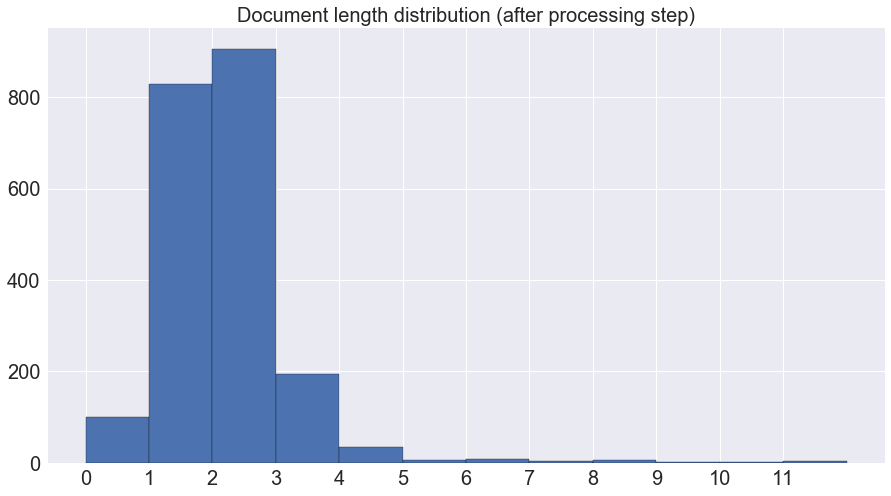

In [14]:
set_size()
plot_distribution(plt, 
                  mooc_tags['length'], 
                  'Document length distribution (after processing step)'
                 )

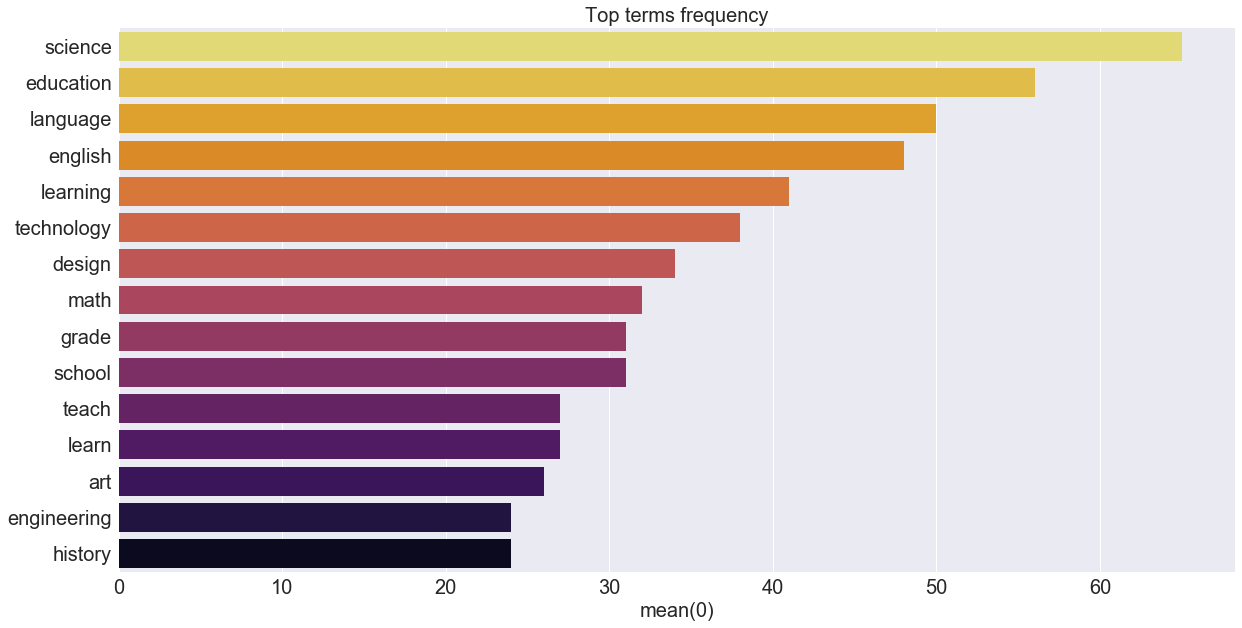

In [15]:
set_size()
plot_frequency(mooc_tags['processed_text'], title = 'Top terms frequency', plt=plt)

In [7]:
"Load pre-train model"

now = time.time()
"""
    Download word2vec pre-trained model at : "https://code.google.com/archive/p/word2vec/"
"""

word2vec_path = "/Users/Cescnghia/Documents/dataset/GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

"Download pre-trained model at https://fasttext.cc/docs/en/crawl-vectors.html"

fasttext = gensim.models.KeyedVectors.load_word2vec_format("/Users/Cescnghia/Documents/dataset/wiki.en/wiki.en.vec")

print('It took {s} mins to load 2 pretrained models'.format(s=(time.time()-now)/60))

It took 13.019425996144612 mins to load 2 pretrained models


## 1.1) Word2Vec 
<a id='1.1'></a>

### 1.1.1) Word2Vec using a pre-train model of Google

In [17]:
word2vec['king'].shape

(300,)

Each word is depocomsed into 300 dimensions

In [18]:
word2vec.most_similar(positive=['queen', 'men'], negative=['king'], topn=1)

[('women', 0.7216066122055054)]

Queen - King + Man = Women

In [19]:
word2vec.most_similar('england', topn=10)

[('liverpool', 0.7172455787658691),
 ('chelsea', 0.7060471177101135),
 ('fulham', 0.7020782232284546),
 ('tottenham', 0.6907042860984802),
 ('rooney', 0.6863133907318115),
 ('man_utd', 0.6844729781150818),
 ('torres', 0.6763710379600525),
 ('ronaldo', 0.6757338643074036),
 ('spain', 0.6740614175796509),
 ('gerrard', 0.6709044575691223)]

### 1.1.2) Word2Vec + K means

The simple idea is take all 1-gram tags, transform it into vector and cluster it.

In [20]:
"Number of cluster"
K = 30

In [21]:
word2vec_df = normalized_mooc_tags.copy()
print('There are',len(word2vec_df),'1-gram tags.')

There are 1235 1-gram tags.


For assigning a vector to word using pre-train model of google, we will have a problem with words(in our dataset) that are not contained in the word2vec model of google. For instance, I will take only the tags that are in the word2vec model of google.

In [22]:
word2vec_df['meaningful_word2vec'] = word2vec_df['processed_text'].apply(lambda x : x in word2vec)
word2vec_df = word2vec_df[word2vec_df['meaningful_word2vec']==True]
word2vec_df = word2vec_df.reset_index().drop('index', 1)
word2vec_df = word2vec_df[['pos', 'processed_text', 'count']].copy()
word2vec_df.head(10)

pos processed_text  count
0   n             ab      1
1   n        ability      1
2   n       abstract      1
3   n        academy      1
4   n         access      1
5   n  accessability      1
6   n      accessory      1
7   n    accountancy      1
8   n     accounting      1
9   n            ace      1

In [23]:
def word2vector(word):
    return word2vec[word]

In [24]:
word2vec_df['word2vec'] = word2vec_df['processed_text'].apply(word2vector)
word2vec_df.head(10)

pos processed_text  count                                           word2vec
0   n             ab      1  [0.064941406, 0.24121094, 0.05444336, 0.191406...
1   n        ability      1  [0.23828125, 0.125, -0.056640625, 0.050048828,...
2   n       abstract      1  [0.2578125, -0.25195312, 0.044189453, 0.285156...
3   n        academy      1  [-0.22460938, 0.16015625, 0.2421875, -0.199218...
4   n         access      1  [-0.087402344, -0.18652344, -0.15136719, 0.007...
5   n  accessability      1  [0.064453125, 0.08886719, -0.14550781, -0.0075...
6   n      accessory      1  [0.15136719, -0.453125, -0.012878418, -0.15722...
7   n    accountancy      1  [0.03466797, -0.083496094, -0.12451172, 0.2734...
8   n     accounting      1  [-0.020141602, 0.060302734, 0.028686523, 0.026...
9   n            ace      1  [-0.024536133, 0.00970459, 0.19824219, 0.03930...

In [25]:
print('There are',len(word2vec_df),'one gram meaningful')

There are 1078 one gram meaningful


In [26]:
"Data preparation for K-Means algorithm"

vocab_word2vec = np.array(word2vec_df['processed_text'])

X_word2vec = []
for x in word2vec_df['word2vec']:
    X_word2vec.append(list(x))

In [27]:
labels_w2v, centers_w2v, clusters_w2v = \
            k_means(K=K, data=X_word2vec, seed=SEED)

In [28]:
print_cluster(K=K, clusters=clusters_w2v, vocabulary=vocab_word2vec, truncated=True, n=5)

Cluster number:  0
[ beginner, elearning, instruction, instructor, learn,  ]


Cluster number:  1
[ ab, ako, alberta, alice, american,  ]


Cluster number:  2
[ genius, mastery,  ]


Cluster number:  3
[ animal, aquaculture, biodiversity, bird, cod,  ]


Cluster number:  4
[ advertising, content, copyright, cyber, digital,  ]


Cluster number:  5
[ aerospace, analytics, architecture, automation, automobile,  ]


Cluster number:  6
[ apply, assist, augment, begin, borrow,  ]


Cluster number:  7
[ agriculture, baking, bloom, border, chemical,  ]


Cluster number:  8
[ agronomy, biochemistry, bioinformatics, biology, biophysics,  ]


Cluster number:  9
[ access, accessability, accounting, acquisition, activity,  ]


Cluster number:  10
[ ability, appreciation, autonomy, character, chemistry,  ]


Cluster number:  11
[ arts, citizenship, civic, civilization, community,  ]


Cluster number:  12
[ accessory, acid, acl, ancient, arrow,  ]


Cluster number:  13
[ autocad, canada, linux, matla

## 1.2) Fasttext 
<a id='1.2'></a>

### 1.2.1) Fasttext +  Kmeans

In [29]:
"""
    Since fasttext is a pre-trained model, we have to remove terms in our dataset that are not included
    in the fasttext model
"""

fasttext_df = normalized_mooc_tags.copy()
fasttext_df['meaningful_fasttext'] = fasttext_df['processed_text'].apply(lambda x : x in fasttext)
fasttext_df = fasttext_df[fasttext_df['meaningful_fasttext']==True]
#fasttext_df = fasttext_df.drop_duplicates(subset='processed_text', keep='first', inplace=False)
fasttext_df = fasttext_df.reset_index().drop('index', 1)
fasttext_df = fasttext_df[['pos', 'processed_text', 'count']].copy()
fasttext_df.head(10)

pos processed_text  count
0   n             ab      1
1   n        ability      1
2   n       abstract      1
3   n        academy      1
4   n         access      1
5   n  accessability      1
6   n      accessory      1
7   n    accountancy      1
8   n     accounting      1
9   n            ace      1

In [30]:
fasttext_df['fasttext'] = fasttext_df['processed_text'].apply(lambda x : fasttext[x])
fasttext_df.head()

pos processed_text  count                                           fasttext
0   n             ab      1  [-0.0232, -0.63172, 0.0064282, -0.28996, -0.07...
1   n        ability      1  [-0.098041, 0.1796, -0.57259, 0.073026, -0.084...
2   n       abstract      1  [0.17572, 0.3706, -0.31275, 0.289, 0.17087, 0....
3   n        academy      1  [0.055129, -0.26567, 0.21295, 0.020666, -0.009...
4   n         access      1  [0.11133, 0.092581, 0.022928, 0.061387, -0.102...

In [31]:
"Data preparation for clustering"

vocab_fasttext = np.array(fasttext_df['processed_text'])
X_fasttext = []
for x in fasttext_df['fasttext']:
    X_fasttext.append(list(x))
    
    
"PCA on X"
tsne_model = TSNE(perplexity=K, n_components=2, init='pca', method='exact',n_iter=2000, random_state=SEED)
tsne_X = tsne_model.fit_transform(X_fasttext)

In [32]:
labels_fasttext, centers_fasttext, clusters_fasttext = \
            k_means(K=K, data=tsne_X, seed=SEED)

In [33]:
print_cluster(K=K, clusters=clusters_fasttext, vocabulary=vocab_fasttext , truncated=True, n=5)

Cluster number:  0
[ algebra, algorithm, arithmetic, astronomy, calculation,  ]


Cluster number:  1
[ ace, adult, age, ako, ap,  ]


Cluster number:  2
[ addition,  ]


Cluster number:  3
[ abstract, aesthetic, animation, art, arts,  ]


Cluster number:  4
[ chain, colour, cs, csp, density,  ]


Cluster number:  5
[ alberta, asia, cairo, california, canada,  ]


Cluster number:  6
[ administration, administrator, advisor, advocacy, beginner,  ]


Cluster number:  7
[ activity, aquaculture, augment, bird, cod,  ]


Cluster number:  8
[ aplicaciones, aprendizagem, artes, autoestima, autonoma,  ]


Cluster number:  9
[ adhd, andragogy, anthropology, asd, autism,  ]


Cluster number:  10
[ agriculture, agronomy, behavioral, behaviour, biochemistry,  ]


Cluster number:  11
[ ability, aid, animal, appreciation, argumentation,  ]


Cluster number:  12
[ analysis, application, atom, bonding, ccls,  ]


Cluster number:  13
[ ancient, choir, citizenship, consultant, dance,  ]


Cluster number:

In [34]:
"Store the result of k-means algorithm"


fasttext_df['x'] = tsne_X[:,0]
fasttext_df['y'] = tsne_X[:,1]
fasttext_df['cluster'] = labels_fasttext
fasttext_df['cluster_center'] = fasttext_df['cluster'].apply(lambda x : centers_fasttext[x])

# 1.3) Visualization
<a id='1.3'></a>

### 1.3.1) All mooc tags

In [59]:
def generating_k_colors(K):
    "Generate k random colors"
    r = lambda: np.random.randint(0,255)

    colors = ['#%02X%02X%02X' % (r(),r(),r()) for x in range(K)]
    
    return colors

In [36]:
"Generate k random colors"
cluster_colors = generating_k_colors(K)

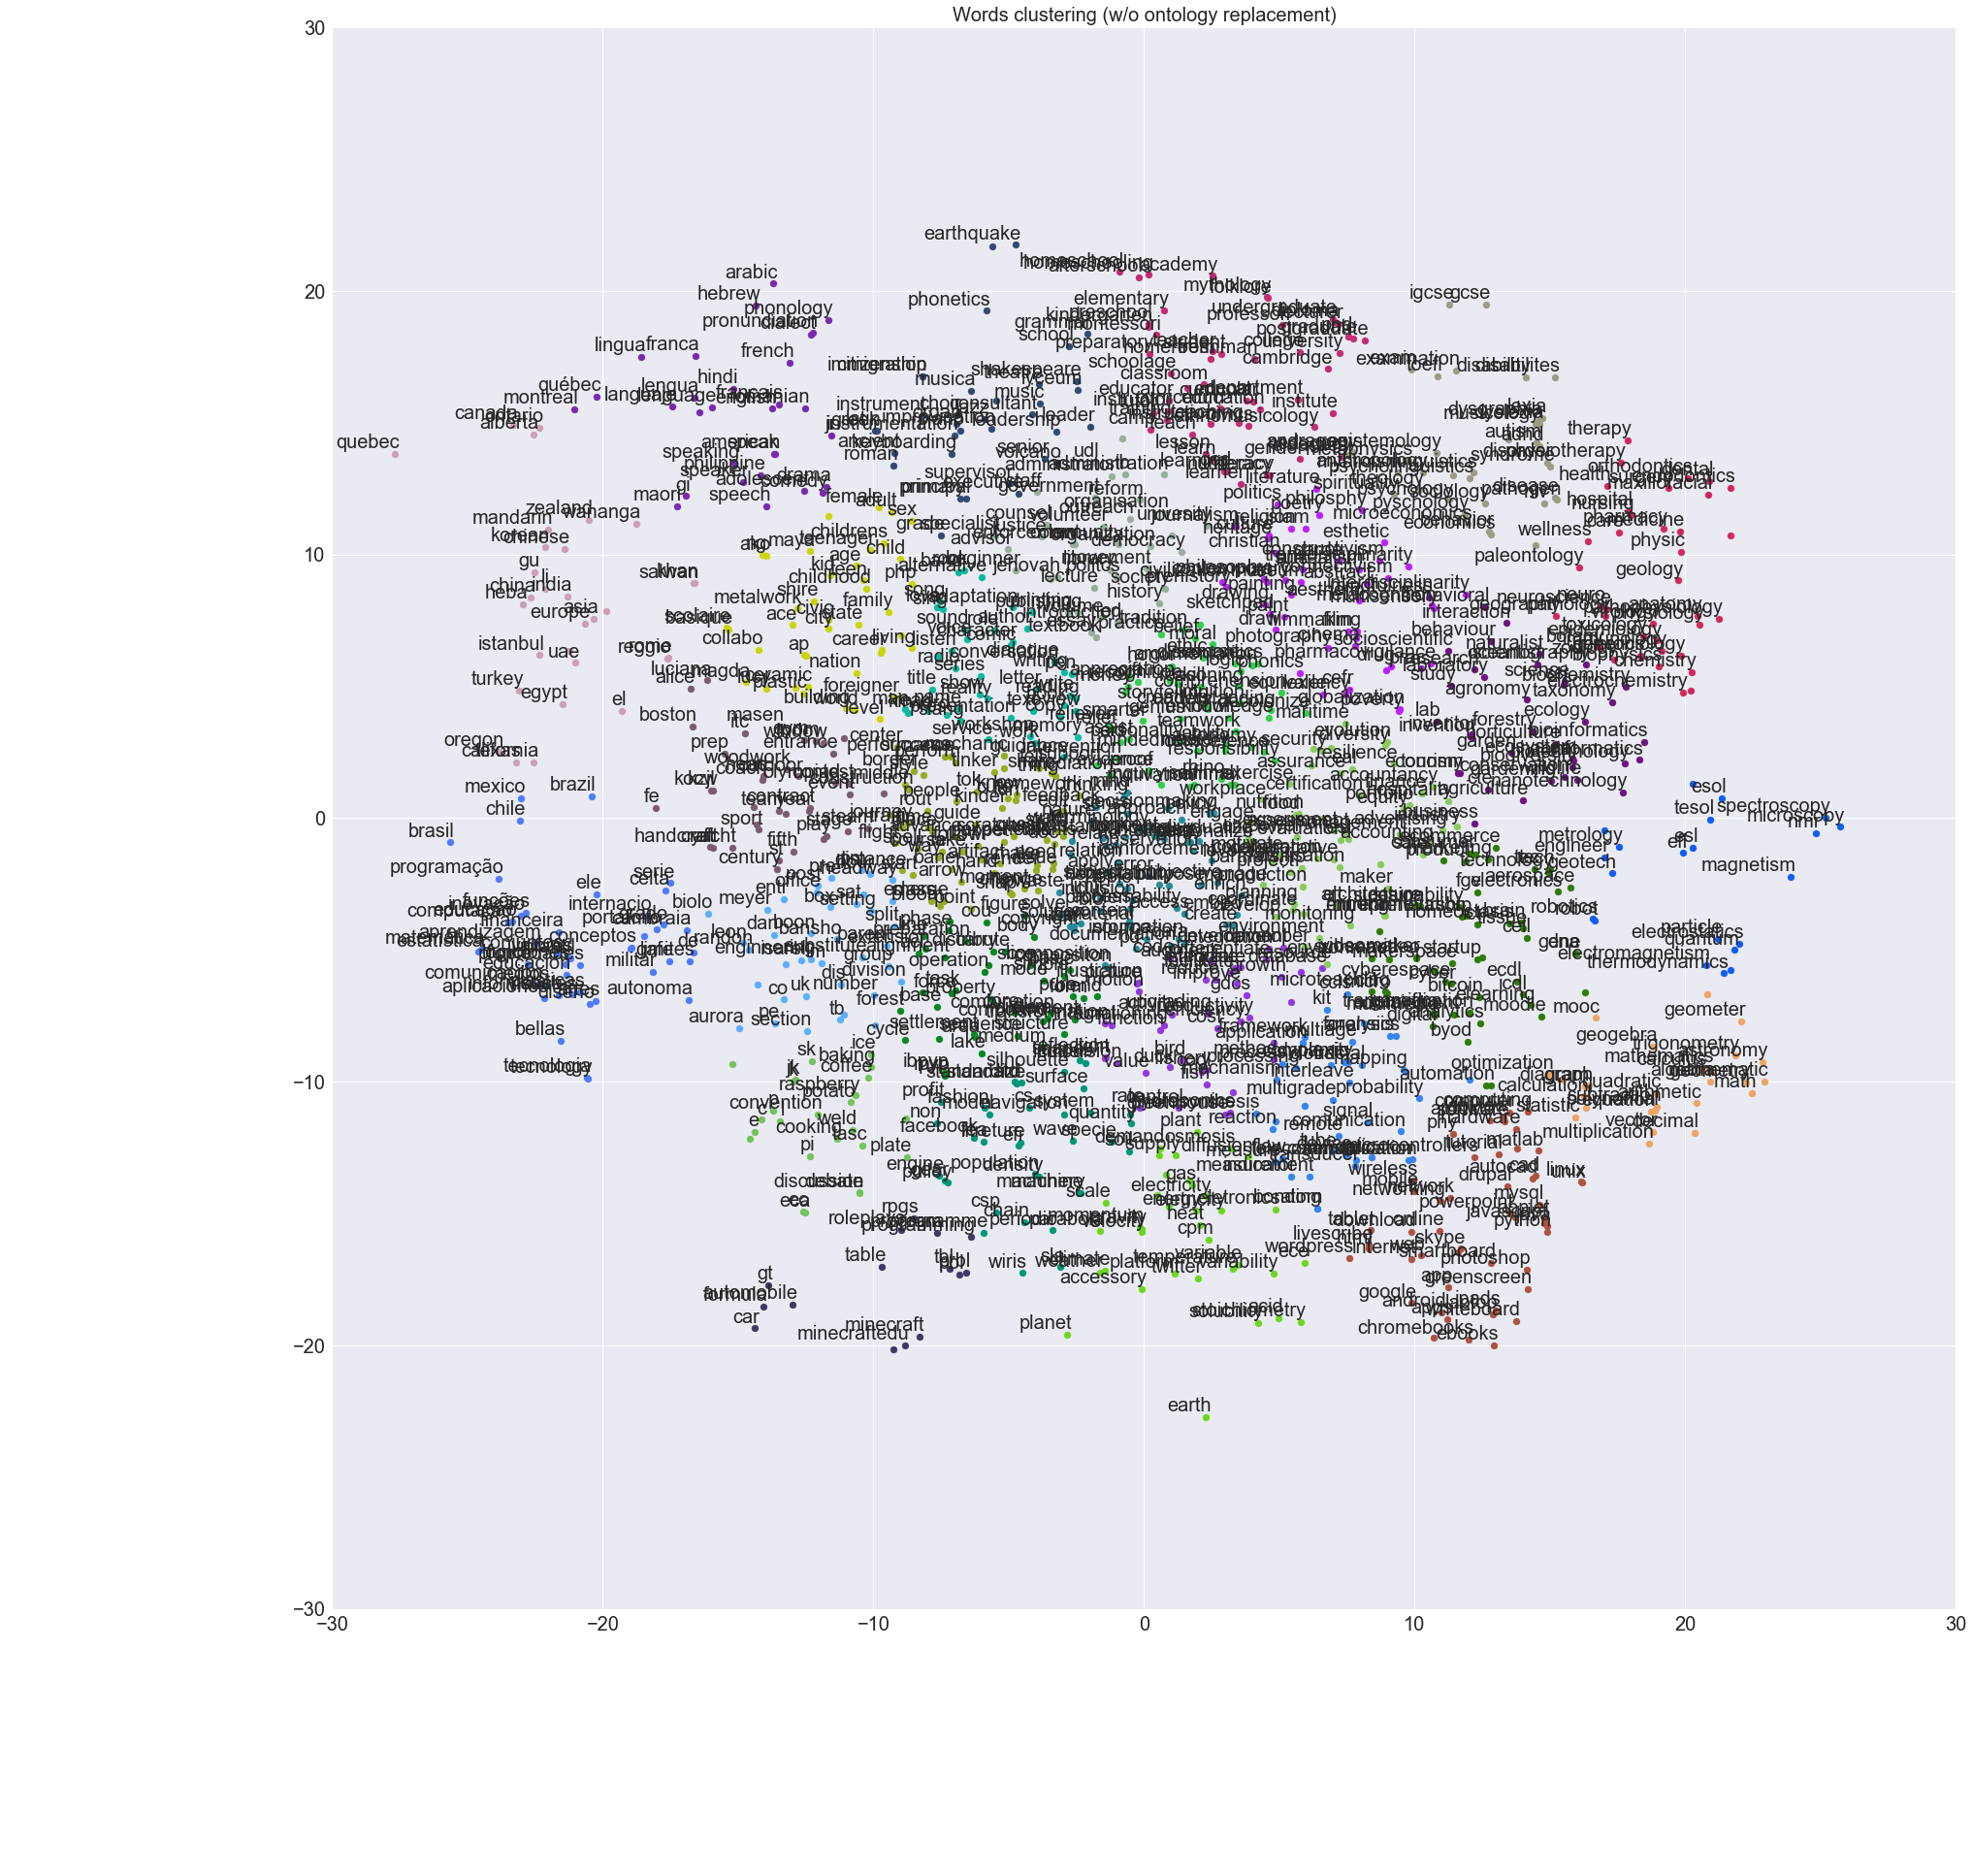

In [37]:
visualisation_normalized_word(K=K, 
              data=tsne_X,
              vocabulary=vocab_fasttext,
              assignment=labels_fasttext,
              colors=cluster_colors,
              plt=plt,
              title='Words clustering (w/o ontology replacement)',
              xlim=30,
              ylim=30)

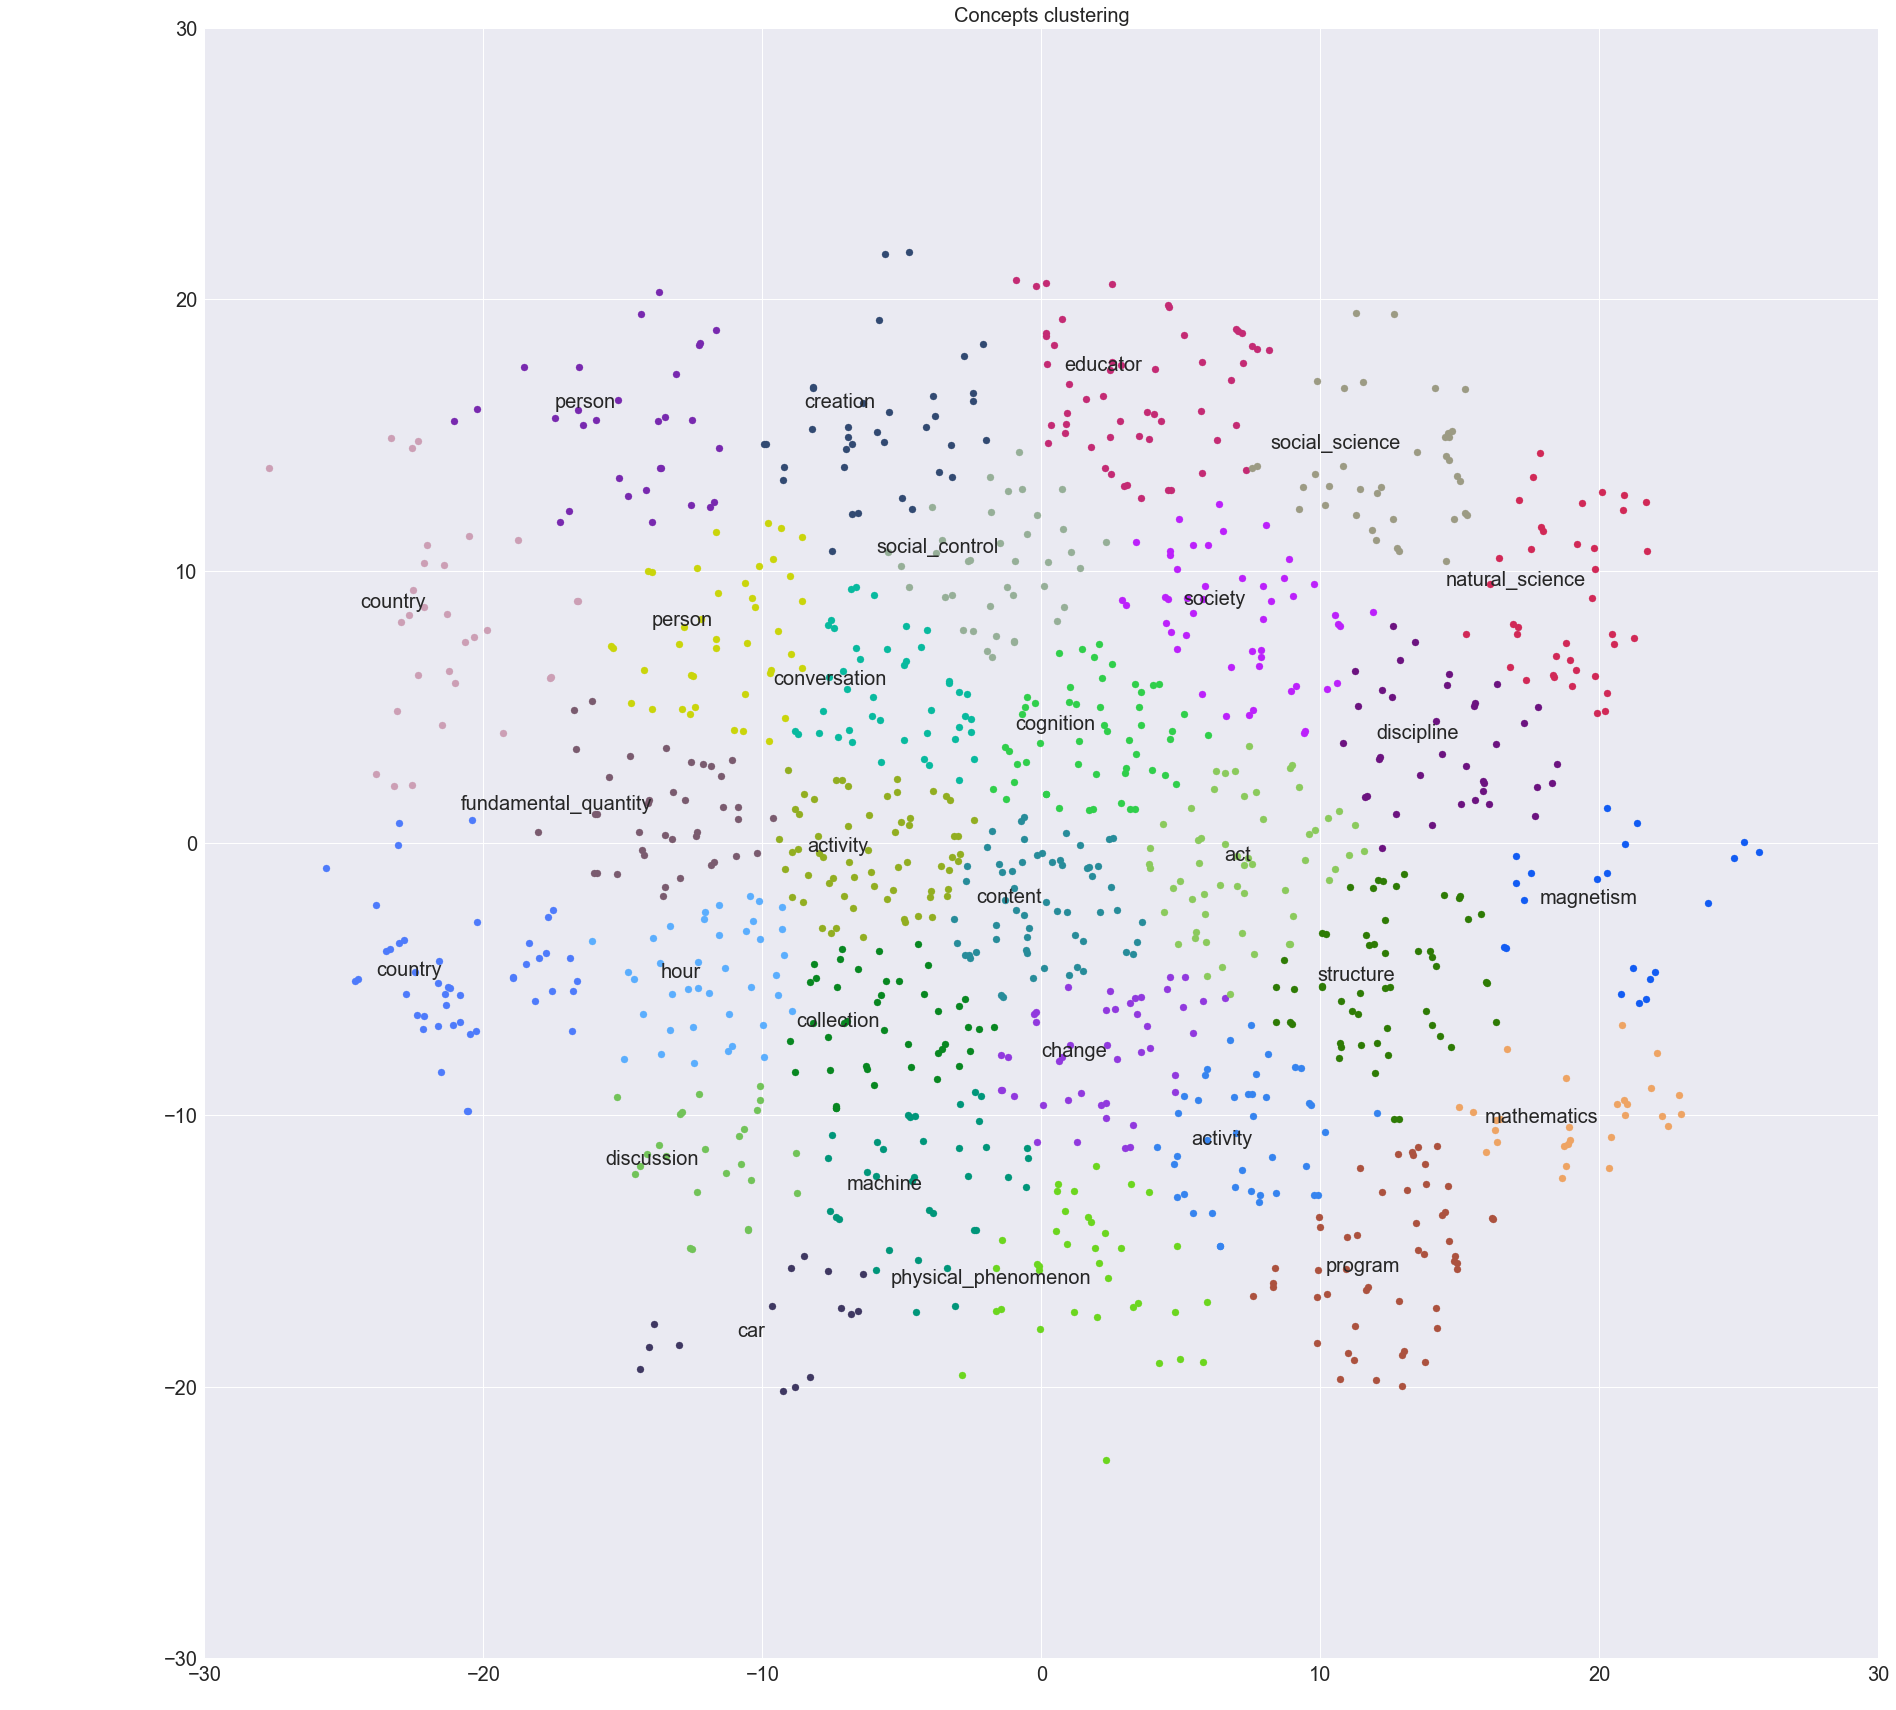

In [38]:
fasttext_df = find_concept_wordnet(K, fasttext_df, max_depth=3)

visualisation_normalized_word(K=K, 
              data=tsne_X,
              vocabulary=vocab_fasttext,
              assignment=labels_fasttext,
              colors=cluster_colors,
              plt=plt,
              title='Concepts clustering',
              xlim=30,
              ylim=30,
              centralword=True,
              df=fasttext_df,
              textfield = 'wordnet')

### 1.3.2 Using ConceptNet to find concept for each cluster

In [39]:
"""
    An example of conceptnet.io
"""

test = 'french'

obj = requests.get('http://api.conceptnet.io/c/en/' + test).json()['edges']
for i in range(len(obj)):
    if obj[i]['surfaceText']:# and 'is a type of' in obj[i]['surfaceText']:
        print(obj[i]['surfaceText'])

[[French]] is [[a language]]
[[Français]] is a translation of [[French]]
[[Français]] is a translation of [[French]]
[[language]] is related to [[french]]
[[French]] is used in the region of [[France]]
[[Anglo-French]] is a type of [[French]]
[[Canadian French]] is a type of [[French]]
[[French]] is [[a human language]]
[[French]] is a type of [[Romance]]
[[Langue d oc]] is a type of [[French]]
[[Langue d oil]] is a type of [[French]]
[[Norman-French]] is a type of [[French]]
[[Old French]] is a type of [[French]]
[[Walloon]] is a type of [[French]]
[[French]] is a way to [[cut]]


In [ ]:
#fasttext_df = find_concept_conceptnet(K=K, df=fasttext_df)

#visualisation_normalized_word(K=K, 
#              data=tsne_X,
#              vocabulary=vocab_fasttext,
#              assignment=labels_fasttext,
#              colors=cluster_colors,
#              plt=plt,
#              xlim=30,
#              ylim=30,
#              centralword=True,
#              df=fasttext_df,
#              textfield = 'conceptnet')

# 2) Reflection questions dataset
<a id='2'></a>

In [535]:
"""First, open file inqreflection.tsv, 
delete some irrelevant row from line 2400 to 2409"""

ref = pd.read_csv('data/inqreflections.tsv', header = None, sep = '\t', encoding = "ISO-8859-1")
ref = ref.iloc[1:].reset_index().drop('index', 1)
ref.columns = ['week', 'text']
ref['week'] = ref['week'].astype(dtype=int)
ref.head()

week                                               text
0     1  {"1": "The WISE simulations allowed the studen...
1     1  {"1": "The most effective aspects in wise acti...
2     1  {"1": "WISE uses predict-observe-explain patte...
3     1  {"1": "It appears that the interactive app all...
4     1  {"1": "Students can make predictions and test ...

In [536]:
ref.tail()

week                                               text
2422     6  {"1": "In chronic recurrent sialadenitis or ch...
2423     1  {"1": "In chronic recurrent sialadenitis or ch...
2424     5  {"1": "Last year my class created a booklet ca...
2425     1  {"1": "Practical examples using excellent visu...
2426     6  {"1": "As in all classrooms there are many div...

In [41]:
"""
Let print out an entry at index 2423:
As we can see, there are two responses for two different question in this week (1 in this case)
Response is contained in a dictionary

"1":.... , "2".......
        
"""

ref.iloc[2423]['responses']

'{"1": "In chronic recurrent sialadenitis or chronic sclerosing sialadenitis, acute attacks are managed with conservative therapies such as hydration, analgesics (mainly NSAIDs), sialogogues to stimulate salivary secretion, and regular, gentle gland massage.[1] If infection is present, appropriate cultures should be obtained, followed by empirical antibiotic therapy initially,[1] for example amoxicillin/clavulanate or clindamycin which cover oral flora.\\\\r\\\\n\\\\r\\\\nIf there are attacks more than approximately 3 times per year or severe attacks, surgical excision of the affected gland should be considered.[1]", "2": "In chronic recurrent sialadenitis or chronic sclerosing sialadenitis, acute attacks are managed with conservative therapies such as hydration, analgesics (mainly NSAIDs), sialogogues to stimulate salivary secretion, and regular, gentle gland massage.[1] If infection is present, appropriate cultures should be obtained, followed by empirical antibiotic therapy initiall

## 2.1 Processing data
<a id='2.1'></a>

In [45]:
ref.tail()

week                                               text language
2375     6  [In chronic recurrent sialadenitis or chronic ...       en
2376     1  [In chronic recurrent sialadenitis or chronic ...       en
2377     5  [Last year my class created a booklet called O...       en
2378     1  [Practical examples using excellent visuals. C...       en
2379     6  [As in all classrooms there are many diversiti...       en

In [537]:
ref['text'] = ref['text'].apply(concatenate_responses)
ref.tail()

week                                               text
2422     6  [In chronic recurrent sialadenitis or chronic ...
2423     1  [In chronic recurrent sialadenitis or chronic ...
2424     5  [Last year my class created a booklet called O...
2425     1  [Practical examples using excellent visuals. C...
2426     6  [As in all classrooms there are many diversiti...

In [538]:
"""
    Remove all reponses non english 
"""

ref['language'] = ref['text'].apply(detect_language)
ref = ref[ref['language']=='en']
ref = ref.reset_index().drop('index', 1)

In [526]:
ref.head()

week                                          responses language
0     1  [The WISE simulations allowed the students to ...       en
1     1  [The most effective aspects in wise activity w...       en
2     1  [WISE uses predict-observe-explain patterns wi...       en
3     1  [It appears that the interactive app allowed t...       en
4     1  [Students can make predictions and test them. ...       en

In [43]:


"""
    Preprocessing
"""

ref = standardize_responses(ref, "responses")
ref = processing_responses(ref, 'standardized_responses')
ref.tail()

week                                          responses language  \
2375     6  [In chronic recurrent sialadenitis or chronic ...       en   
2376     1  [In chronic recurrent sialadenitis or chronic ...       en   
2377     5  [Last year my class created a booklet called O...       en   
2378     1  [Practical examples using excellent visuals. C...       en   
2379     6  [As in all classrooms there are many diversiti...       en   

                                 standardized_responses  \
2375  [in chronic recurrent sialadenitis or chronic ...   
2376  [in chronic recurrent sialadenitis or chronic ...   
2377  [last year my class created a booklet called o...   
2378  [practical examples using excellent visuals. c...   
2379  [as in all classrooms there are many diversiti...   

                                    processed_responses  
2375  [chronic recurrent sialadenitis chronic sclero...  
2376  [chronic recurrent sialadenitis chronic sclero...  
2377  [last year class create booklet call solar sys...  
2378  [practical example use excellent visuals chall...  
2379  [classroom many diversity different viewpoint ...

In [44]:
ref['nb_responses'] = ref['processed_responses'].apply(lambda x : len(x))

In [45]:
"Original responses, for instance: list[0] = response for question number 1 and so on"

ref.iloc[14]['responses']

['I liked that the students could move at their own pace without having to bring the whole class back together. Students are being assessed as they work so a teacher would not have to stop the learning process to take a grade. The visuals also appeared helpful and the interaction with the visuals appeared meaningful. ',
 "Jennifer was able to monitor the student's progress and engage in conversation with them about the activity instead of leading the instruction. "]

In [46]:
"Standardized responses"

ref.iloc[14]['standardized_responses']

['i liked that the students could move at their own pace without having to bring the whole class back together. students are being assessed as they work so a teacher would not have to stop the learning process to take a grade. the visuals also appeared helpful and the interaction with the visuals appeared meaningful. ',
 "jennifer was able to monitor the student's progress and engage in conversation with them about the activity instead of leading the instruction. "]

In [47]:
"Processed responses"

ref.iloc[14]['processed_responses']

['like student move pace bring whole class back together student assess work teacher stop learning process take grade visuals also appear helpful interaction visuals appear meaningful',
 'jennifer able monitor student progress engage conversation activity instead lead instruction']

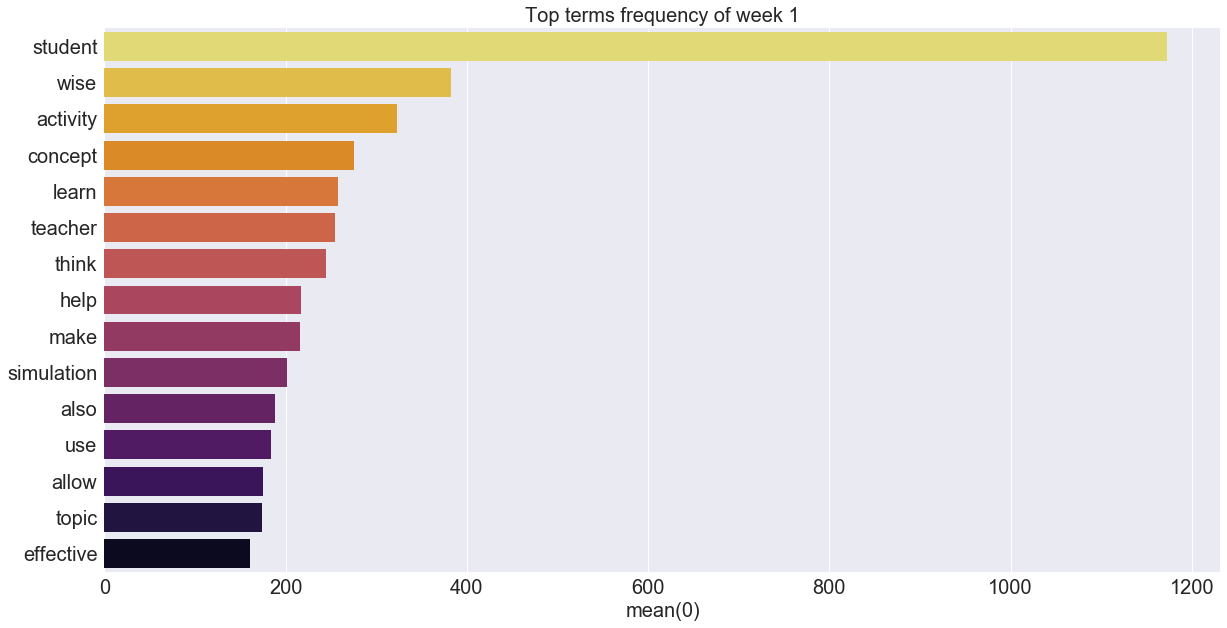

In [48]:
plot_frequency_week(df = ref, week = 1, questionNb = 1, plt = plt)

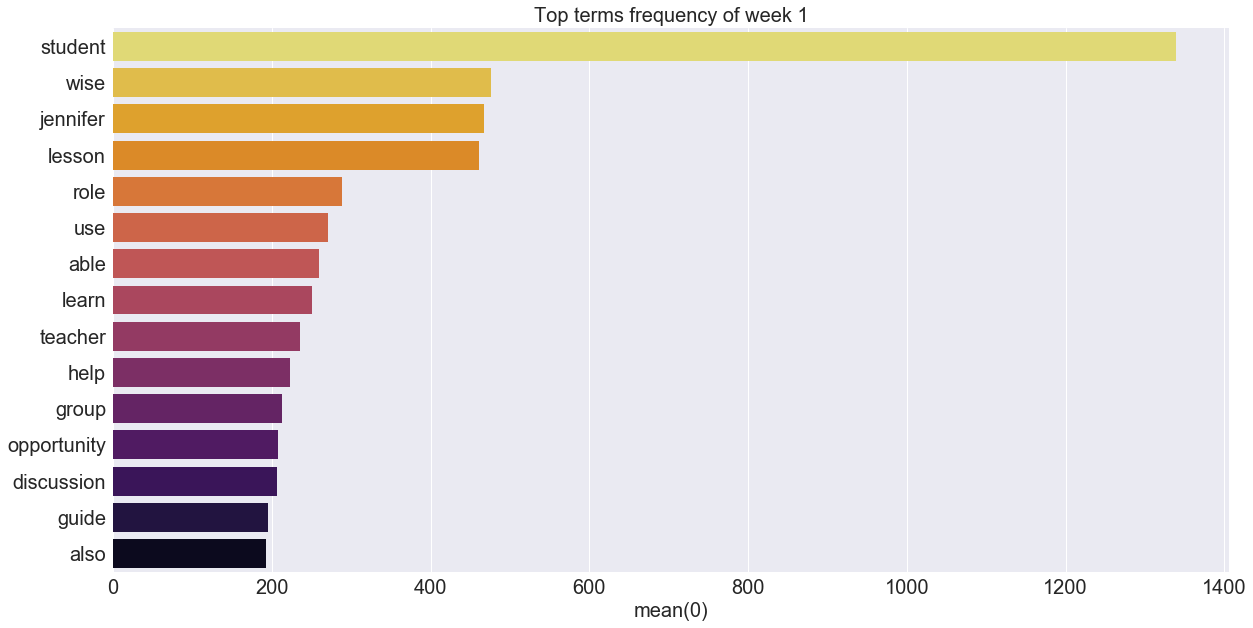

In [49]:
plot_frequency_week(df = ref, week = 1, questionNb = 2, plt = plt)

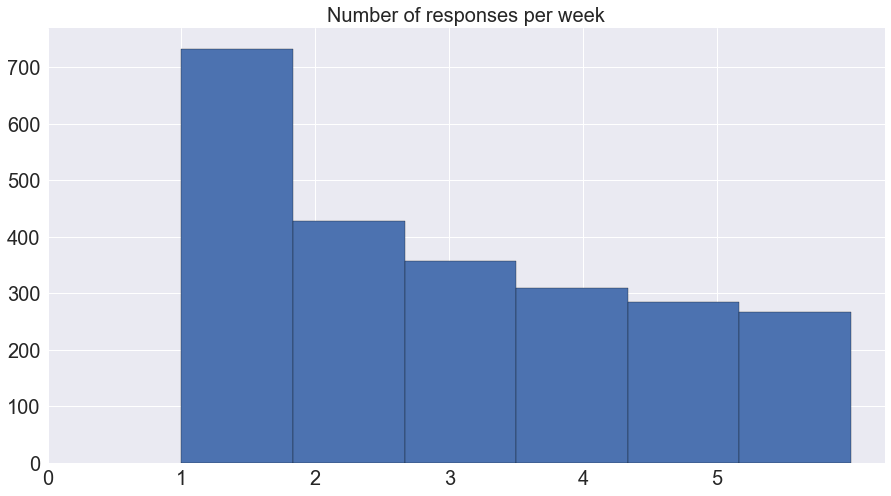

In [50]:
plot_distribution(plt, ref['week'], title="Number of responses per week")

## 2.2) Perform LDA and NMF

<a id='2.2'></a>

In [51]:
TOPICS = 8
N = 5 #retrieve top 10 responses that contribute to each topic

Welcome to LDA algorithm.
Begin find topics for all answers of question number 1 of week 1
Shape of tfidf matrix: (733, 2040)
Topic words distribution shape: (8, 2040)


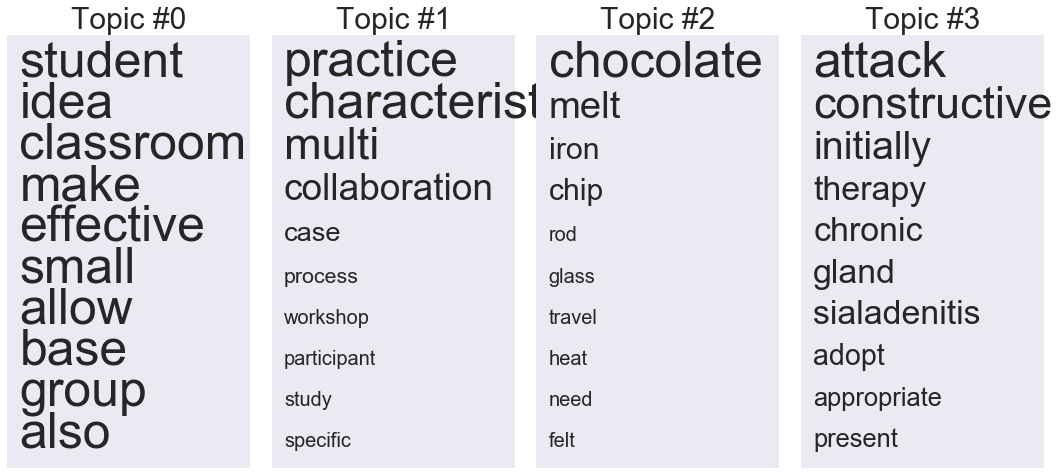

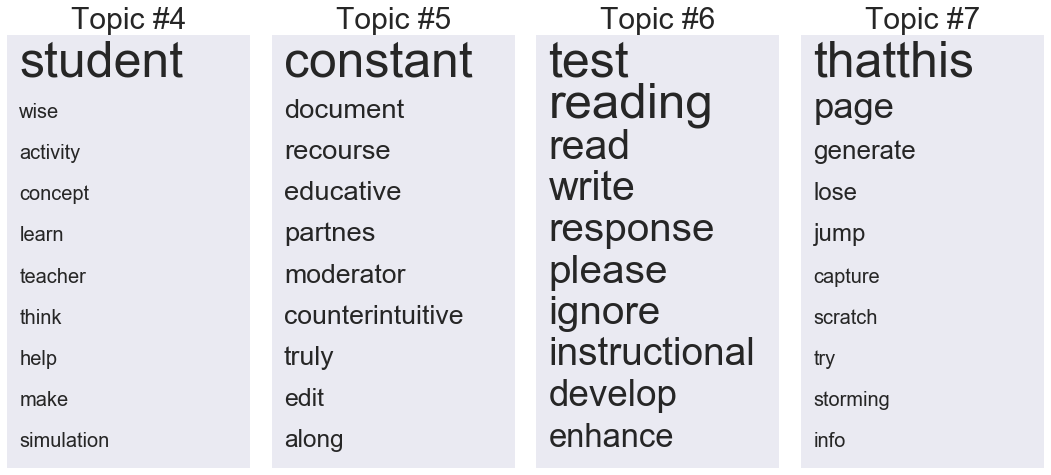

In [52]:
"LDA"

df_lda, sentsTopic_lda, topicsSent_lda = LDA(df = ref, 
                                             week = 1, 
                                             questionNb = 1, 
                                             nbTopic = TOPICS, 
                                             n = N,
                                             plt=plt)

Welcome to NMF algorithm.
Begin find topics for all answers of question number 1 of week 1
Shape of tfidf matrix: (733, 228)
Topic words distribution shape: (8, 228)


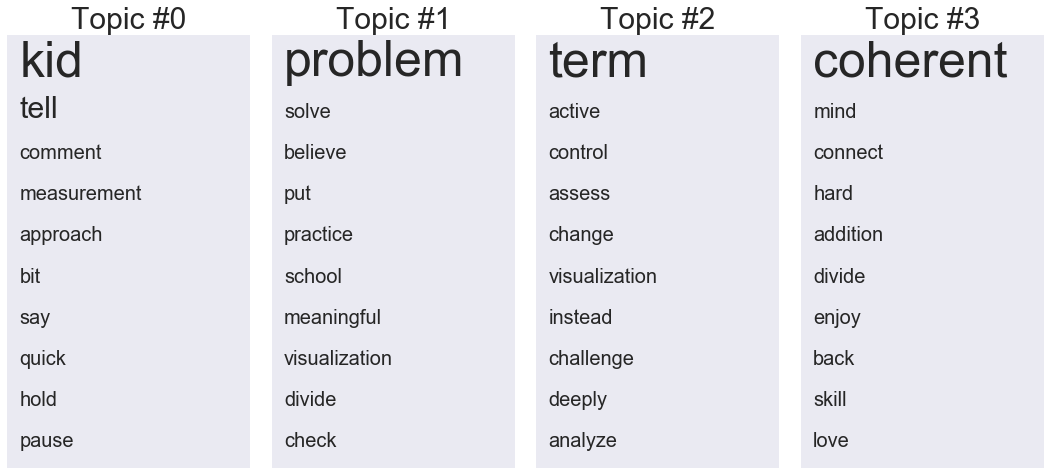

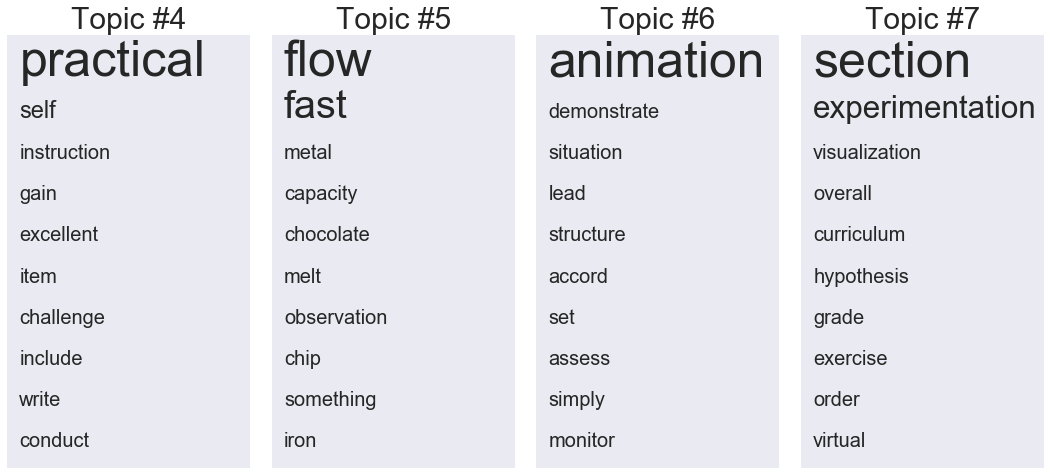

In [53]:
"Non Negative Matrix Factorization"

df_nmf ,sentsTopic_nmf, topicsSent_nmf = nmf(df=ref, 
                                             week=1, 
                                             questionNb = 1, 
                                             nbTopic=TOPICS, 
                                             n=N,
                                             plt=plt)
                                             


In [54]:
"""
    Top N responses with the highest similarity with topic 7
"""

print_top_responses_for_topic(sentsTopic_lda, 7, N)

Top 5 responses that contribute for Topic #7
***************
***************
***************
['that they have a page by page guideline of what to do. lots of times my students try jumping ahead and they lose out on the scaffolding. ', 'she was there to answer questions  and ensure that students were progressing appropriately. if she saw common misconceptions or ideas among groups  then it was something she could address to the class. she also led class discussions during pauses of the wise activity.']
--------------------------------------------------
['this and that this and thatthis and thatthis and thatthis and thatthis and thatthis and that', 'that and thisthis and thatthis and thatthis and thatthis and thatthis and thatthis and thatthis and thatthis and that']
--------------------------------------------------
['tailoring lesson plans to suite students. anonymous answer reviews   removes or reduces anxiety and stress for the weaker students which helps to prevent them from losing 

In [55]:
"""
    Find which topics have the most contribution for a specific response
"""

for responseID in range (10):
    print_top_topics_for_response(topicsSent_lda, responseID, N)

Response 0: 0.98*Topic4 + 0.00*Topic2 + 0.00*Topic3 + 0.00*Topic0 + 0.00*Topic5
Response 1: 0.97*Topic4 + 0.00*Topic1 + 0.00*Topic6 + 0.00*Topic0 + 0.00*Topic5
Response 2: 0.92*Topic4 + 0.01*Topic7 + 0.01*Topic0 + 0.01*Topic5 + 0.01*Topic6
Response 3: 0.81*Topic4 + 0.14*Topic3 + 0.00*Topic1 + 0.00*Topic0 + 0.00*Topic5
Response 4: 0.89*Topic4 + 0.01*Topic6 + 0.01*Topic0 + 0.01*Topic5 + 0.01*Topic7
Response 5: 0.99*Topic4 + 0.00*Topic7 + 0.00*Topic3 + 0.00*Topic1 + 0.00*Topic2
Response 6: 0.92*Topic4 + 0.01*Topic3 + 0.01*Topic2 + 0.01*Topic0 + 0.01*Topic5
Response 7: 0.95*Topic4 + 0.00*Topic7 + 0.00*Topic2 + 0.00*Topic0 + 0.00*Topic5
Response 8: 0.98*Topic4 + 0.00*Topic2 + 0.00*Topic7 + 0.00*Topic1 + 0.00*Topic0
Response 9: 0.95*Topic4 + 0.00*Topic2 + 0.00*Topic3 + 0.00*Topic0 + 0.00*Topic5


## 2.3) Fasttext + Ontology + LDA
<a id='2.3'></a>

* Combine Fasttext, Ontology and LDA

In [56]:
ref = extracting_onto(ref, 'standardized_responses', 'nouns_verbs')
ref.head()

week                                          responses language  \
0     1  [The WISE simulations allowed the students to ...       en   
1     1  [The most effective aspects in wise activity w...       en   
2     1  [WISE uses predict-observe-explain patterns wi...       en   
3     1  [It appears that the interactive app allowed t...       en   
4     1  [Students can make predictions and test them. ...       en   

                              standardized_responses  \
0  [the wise simulations allowed the students to ...   
1  [the most effective aspects in wise activity w...   
2  [wise uses predict observe explain patterns wi...   
3  [it appears that the interactive app allowed t...   
4  [students can make predictions and test them. ...   

                                 processed_responses  nb_responses  \
0  [wise simulation allow student conceptualize a...             2   
1  [effective aspect wise activity create spirit ...             2   
2  [wise use predict observe explain pattern prom...             2   
3  [appear interactive app allow visualize scienc...             2   
4  [student make prediction test work small group...             2   

                                         nouns_verbs  
0  [wise simulation allow student conceptualize i...  
1  [aspect wise activity create spirit team encou...  
2  [wise use predict observe explain pattern prom...  
3  [appear app allow visualize science reflect go...  
4  [student make prediction test work group  , se...

In [57]:
"Count number of nouns and verbs before replacing"

ontology_features = count(ref, 'nouns_verbs')

There are 5277 nouns and verbs in the dataset


In [58]:
"Mapping noun/verb to a vector using Fasttext/Word2Vec"

ontology2fas = []
ontology2vec = []
for ontology in ontology_features:
    if ontology in fasttext:
        ontology2fas.append(fasttext[ontology])
    else:
        ontology2fas.append(np.array([0.0]*300))
        
for ontology in ontology_features:
    if ontology in word2vec:
        ontology2vec.append(word2vec[ontology])
    else:
        ontology2vec.append(np.array([0.0]*300))
        
        
analysis_noun_df = pd.DataFrame({
                        'ontology_features' : ontology_features,
                        'fasttext' : ontology2fas,
                        'word2vec' : ontology2vec
                    })
analysis_noun_df.head()

fasttext ontology_features  \
0  [-0.46529, -0.0041742, -0.29827, 0.5952, -0.36...              aand   
1  [-0.0232, -0.63172, 0.0064282, -0.28996, -0.07...                ab   
2  [0.037252, -0.016389, -0.62663, -0.010042, -0....          abilites   
3  [-0.098041, 0.1796, -0.57259, 0.073026, -0.084...           ability   
4  [-0.030951, -0.036293, -0.26573, 0.34186, -0.3...          abilties   

                                            word2vec  
0  [0.084472656, -0.010498047, -0.104003906, 0.20...  
1  [0.064941406, 0.24121094, 0.05444336, 0.191406...  
2  [0.10498047, 0.111816406, 0.075683594, -0.0134...  
3  [0.23828125, 0.125, -0.056640625, 0.050048828,...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [59]:
"Example of some useful functions in Fasttext "

a = fasttext['carpentry']
b = fasttext['woodcutting']
cosine_similarity(a, b)

array([[0.6145797]], dtype=float32)

In [60]:
"Most similar to the word `carpentry` according to Fasttext"

#fasttext.most_similar('carpentry')

'Most similar to the word `carpentry` according to Fasttext'

In [61]:
"Compute the cosin similarity between noun"

X = [x.tolist() for x in analysis_noun_df['fasttext']]
distances_matrix = cosine_similarity(X, X)

"Then find the most similar"

features = np.array(ontology_features)
for idx, noun in enumerate(features):
    if (idx < 50 and idx > 40): # Print a few terms
        min_distances = distances_matrix[idx,:].argsort()[::-1][1:5]
        print('Top closest words with `{n}`'.format(n=noun))
        print(features[min_distances])
        print(distances_matrix[idx,:][min_distances])
        print('---------------------')

Top closest words with `accumulate`
['amass' 'collect' 'absorb' 'amount']
[0.5772852  0.55280498 0.54414115 0.54024794]
---------------------
Top closest words with `accuracy`
['accurate' 'precision' 'reliability' 'precise']
[0.7257426  0.68427598 0.67939313 0.61525144]
---------------------
Top closest words with `accurate`
['precise' 'accuracy' 'correct' 'reliably']
[0.74164024 0.7257426  0.67904365 0.63412565]
---------------------
Top closest words with `accustom`
['custom' 'instruct' 'endure' 'mindful']
[0.54153154 0.51714454 0.50653125 0.50211579]
---------------------
Top closest words with `ace`
['pilot' 'charley' 'card' 'kid']
[0.44535383 0.37461949 0.36595719 0.34975343]
---------------------
Top closest words with `acheive`
['achieve' 'achievment' 'accomplish' 'thats']
[0.63714701 0.62186611 0.56187458 0.55692392]
---------------------
Top closest words with `achieve`
['achieving' 'attain' 'accomplish' 'gain']
[0.80777509 0.77095131 0.72676383 0.64183308]
-------------------

In [62]:
replace = find_top_most_similarity(ontology_features, analysis_noun_df, threshold = .9)

=====> We can replace `achivement` by `achivements`
---------------------
=====> We can replace `achivements` by `achivement`
---------------------
=====> We can replace `adaptation` by `adaption`
---------------------
=====> We can replace `adaption` by `adaptation`
---------------------
=====> We can replace `adviser` by `advisor`
---------------------
=====> We can replace `advisor` by `adviser`
---------------------
=====> We can replace `allows` by `enables`
---------------------
=====> We can replace `angeles` by `los`
---------------------
=====> We can replace `anybody` by `anyone`
---------------------
=====> We can replace `anyone` by `anybody`
---------------------
=====> We can replace `assigment` by `assigments`
---------------------
=====> We can replace `assigments` by `assigment`
---------------------
=====> We can replace `behavior` by `behaviour`
---------------------
=====> We can replace `behaviour` by `behavior`
---------------------
=====> We can replace `colabora

In [63]:
"Let see now, after the replacement, how many nouns do we have"

_ = count(ref, 'nouns_verbs',replacement=True, replace=replace)

There are 5261 nouns and verbs in the dataset


Welcome to LDA algorithm.
Begin find topics for all answers of question number 1 of week 1
Shape of tfidf matrix: (733, 2037)
Topic words distribution shape: (8, 2037)


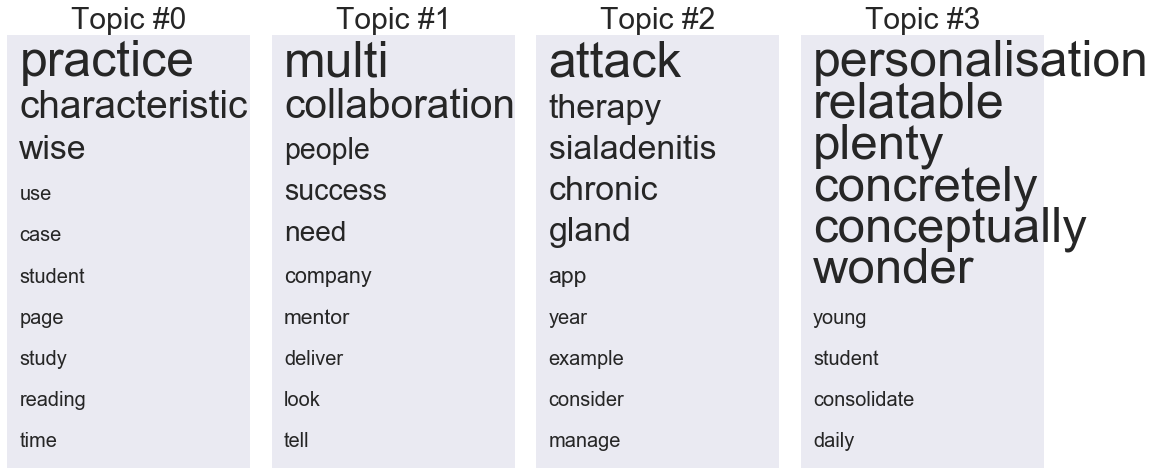

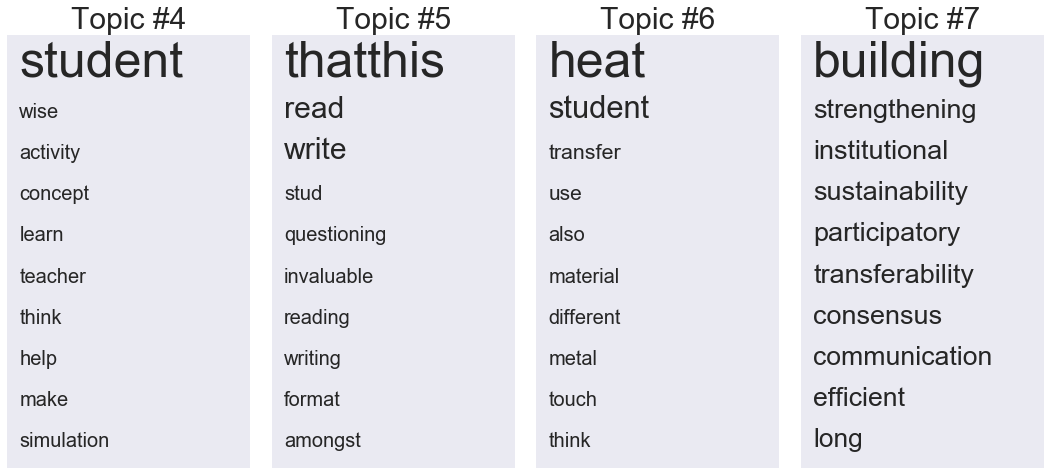

In [64]:
_, sentsTopic_lda_onto, topicsSent_lda_onto = LDA(df = ref, 
                                                       week = 1,
                                                       questionNb = 1, 
                                                       nbTopic = TOPICS, 
                                                       n = N,
                                                       plt=plt,
                                                       replacement=True,
                                                       replace=replace)

## 2.4) Latent semantic indexing

<a id='2.4'></a>

### 2.4.1) Students' responses - concept space similarity

In [65]:
df_resp_1 = search(df=ref, 
                   week=1, 
                   questionNb=1, 
                   latentSpace=100, 
                   yourConcept='hot chocolate',
                   n=N)

There are 733 responses in 2040 significant terms
-------------------------------
Student 414 has score 1.7367438580399925
Student 170 has score 1.5258555164675531
Student 347 has score 1.4181965268470966
Student 582 has score 1.4132469446606708
Student 672 has score 1.3358445929797238


In [66]:
df_resp_1.iloc[414]['responses']

['1.  They felt the objects by themselves\\r\\n2.   They melted chocolate bars on hot iron and glass\\r\\n3.   They got to know why heat transported more quickly through some more than others',
 'She found herself moving from one point to the other, guiding and facilitating. It really made her job much easier.']

In [67]:
df_resp_1.iloc[170]['responses']

['I think the area where students explored in melting chocolate chips and touching an iron with different bars made of glass and metal really gave a huge understanding to the students. ',
 "Jennifer's role during the lesson was to check students understanding and guide them correctly by discussing the subject matter with the students. The new opportunities that comes as a result of using WISE is the teacher was able to detect when the students were getting stuck and how she can be of help to them. It makes it easy for the teacher to get her own copy of any lesson. It also help the teacher to develop some great ideas on how to run the activity next time maybe by modifying her lessons, planning for more activities, or asking different questions."]

In [119]:
df_resp_2 = search(df=ref, 
                   week=1, 
                   questionNb=1, 
                   latentSpace=100, 
                   yourConcept='poisson distribution',
                   n=N)

There are 733 responses in 2040 significant terms
-------------------------------
Student 719 has score 1.0000000000000002
Student 551 has score 0.3277531409934398
Student 222 has score 0.2865142636208985
Student 271 has score 0.26801423055673024
Student 374 has score 0.26684476535342616


In [121]:
df_resp_1.iloc[719]['responses'][0]

'Some of the most effective aspects of WISE platform is the capacity to approach the content of a subject, for instance a unit and the teacher to be able to develop a coherent distribution of activities in order to understand that particular concept. So this activities are simulations, explanations, predicctions etc. There are different way to explain a concept, also when students bring preconceived ideas to this concepts. Feedback it is very important and valuable in this WISE activity, as well it offers activities to work with others.'

### 2.4.2) Students' responses similarity

In [69]:
scores, new_df, U, V, vocab = compute_response_similarity(df=ref, 
                                                          week=1, 
                                                          questionNb=1, 
                                                          latentSpace=100, 
                                                          n = N)

There are 733 responses in 2040 significant terms
Top 5 responses similarity for each student
Student 0: 
-------Student 0 with score: 1.0000000000000002
-------Student 529 with score: 0.5061267773024262
-------Student 2 with score: 0.4729180164894371
-------Student 302 with score: 0.4455428108262425
-------Student 711 with score: 0.40280696144132594
Student 1: 
-------Student 1 with score: 1.0
-------Student 350 with score: 0.7457309278405372
-------Student 584 with score: 0.7115321965536509
-------Student 65 with score: 0.628350515340317
-------Student 478 with score: 0.5935951137553042
Student 2: 
-------Student 2 with score: 1.0
-------Student 0 with score: 0.4729180164894371
-------Student 429 with score: 0.461538745430097
-------Student 49 with score: 0.4430883871745878
-------Student 686 with score: 0.44141460183950376
Student 3: 
-------Student 3 with score: 1.0000000000000002
-------Student 610 with score: 0.5349815155399325
-------Student 357 with score: 0.38193464130458643
-

In [84]:
"2 students(210 and 534) has a high similarity score with student 101"

new_df.iloc[101]['responses'][0]

'The most  effective aspects of the WISE activity were  the different simulations that gave students a picture in their mind of how to see a heat moving through a system. The WISE activity breaks down concepts into very small manageable pieces, and then it helps students to build  those ideas up to a more coherent understanding.'

In [85]:
new_df.iloc[210]['responses'][0]

'WISE activity breaks down concepts into very small, manageable pieces, gave them a picture in their mind of how to see the heat moving through a system. And then it helps the students, scaffolds them, to kind of build those ideas up to a more coherent understanding. \\r\\n'

In [86]:
new_df.iloc[534]['responses'][0]

'WISE activity breaks down concepts into very small, manageable pieces, and then it helps the students, scaffolds them, to kind of build those ideas up to a more coherent understanding.\\r\\n'

In [87]:
"2 students(523 and 297) has a high similarity score with student 725"

new_df.iloc[725]['responses'][0]

'allowing for collaborate with partners and to make and test their predictions, '

In [88]:
new_df.iloc[523]['responses'][0]

'Students were encouraged to reflect on scenarios , collaborate with partners and to make and test predictions.'

In [89]:
new_df.iloc[297]['responses'][0]

'WISE provides various scenarios for learning. It allow student to collaborate with partners, and to make and test their predictions by computer simulation.'

In [90]:
"3 students(671, 209 and 534) has a high similarity score with student 60"

new_df.iloc[60]['responses'][0]

'WISE helps break down concepts into very small, manageable pieces, and then it helps the students, and encourage them to build the ideas. '

In [91]:
new_df.iloc[671]['responses'][0]

'The demostrations she did to students with the WISE activity, breaking down concepts\\r\\ninto very small, manageable pieces,  helping students to build ideas up for an easier comprehension\\r\\n'

In [92]:
new_df.iloc[209]['responses'][0]

'WISE activity breaks down concepts into very small, manageable pieces, and then it helps the students, scaffolds them, to kind of build those ideas up to a more coherent understanding.'

In [93]:
new_df.iloc[534]['responses'][0]

'WISE activity breaks down concepts into very small, manageable pieces, and then it helps the students, scaffolds them, to kind of build those ideas up to a more coherent understanding.\\r\\n'

In [73]:
features_truc = np.array(vocab)
for i in range(100):
    dist = V[:,i]
    max_ = dist.argsort()[::-1][1:10]
    print('Top contributed words for latent `{n}`'.format(n=i))
    print(features_truc[max_])
    print(dist[max_])
    print('---------------------')

Top contributed words for latent `0`
['discussion' 'together' 'coherent' 'guidance' 'learner' 'bit' 'possible'
 'prediction' 'important']
[0.12889609 0.1277532  0.11050614 0.10538416 0.10459435 0.1045188
 0.10430994 0.09749813 0.09531565]
---------------------
Top contributed words for latent `1`
['new' 'helpful' 'content' 'useful' 'opportunity' 'reflect' 'hand' 'try'
 'show']
[0.16666332 0.14648038 0.12462939 0.11961757 0.11905858 0.11795718
 0.11246328 0.11120259 0.10720486]
---------------------
Top contributed words for latent `2`
['share' 'test' 'effective' 'together' 'real' 'break' 'discuss' 'give'
 'work']
[0.1207236  0.11842079 0.11361027 0.11191781 0.10611786 0.10434852
 0.10401384 0.093458   0.08034918]
---------------------
Top contributed words for latent `3`
['gain' 'online' 'felt' 'collaborate' 'whole' 'fact' 'discuss'
 'especially' 'create']
[0.11218999 0.11124999 0.10262926 0.09928363 0.09739107 0.09682004
 0.096086   0.0926603  0.08954952]
---------------------
Top con

## 2.5) K-means

<a id='2.5'></a>

In [97]:
import tensorflow as tf
import tensorflow_hub as hub

In [113]:
def sentence_embeddings(sentences):

    with tf.Graph().as_default():
        embed = hub.Module("https://tfhub.dev/google/nnlm-en-dim128-with-normalization/1")
        embeddings = embed(sentences)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.tables_initializer())

            return sess.run(embeddings)

In [114]:
sentences = ["The university should invest in solar cell panels", 
             "We should all walk more", 
             "The school should reduce it's electricity comsumption",
             "We should use our bicycles more"]

embedded = sentence_embeddings(sentences)

INFO:tensorflow:Initialize variable module/embeddings/part_0:0 from checkpoint b'/var/folders/6l/0zt406zd3v1c3jv20lqlkpmc0000gn/T/tfhub_modules/2cdbcae1a547f4fb93475d4b7d4140f8590995b7/variables/variables' with embeddings


In [115]:
embedded.shape

(4, 128)

In [116]:
cosine_similarity(embedded)

array([[1.0000001 , 0.17557916, 0.5451225 , 0.3656765 ],
       [0.17557916, 1.        , 0.29399598, 0.64525115],
       [0.5451225 , 0.29399598, 1.        , 0.37458077],
       [0.3656765 , 0.64525115, 0.37458077, 1.        ]], dtype=float32)

In [117]:
labels_embedded, centers_embedded, clusters_embedded = k_means(K=2, data=embedded, seed=SEED)

In [118]:
labels_embedded

array([1, 0, 1, 0], dtype=int32)

# 3) Put all things together
<a id='3'></a>

In [74]:
#hyp = pd.read_csv('data/hypothesis.tsv', header = None, sep = '\t', encoding = "ISO-8859-1")
#hyp.columns = ['original', 'annotated', 'source']
#hyp.dropna(inplace=True)
#hyp = hyp.reset_index().drop('index', 1)
#hyp.head(7)

In [400]:
from nltk.corpus import wordnet as wn
from nltk import pos_tag

fruits = ['orange', 'banana', 'apple', 'durian']
countries = ['vietnam', 'switzerland', 'france', 'england']
languages = ['java', 'python', 'scala', 'javascript']

pos = ['n', 'n', 'n', 'n'] # nouns

In [401]:
find_hypernym(fruits, pos, 3)

'edible_fruit'

In [402]:
find_hypernym(countries, pos, 3)

'country'

In [403]:
find_hypernym(languages, pos, 3)

'island'

In [404]:
works = ['carpentry', 'woodworking']
pos_w = ['n', 'n']

find_hypernym(works, pos_w, 3)

'occupation'

In [407]:
syn1 = wn.synset('carpentry.n.01')
syn2 = wn.synset('woodworking.n.01')

syn1._shortest_hypernym_paths(syn2)

{Synset('*ROOT*'): 9,
 Synset('abstraction.n.06'): 7,
 Synset('act.n.02'): 4,
 Synset('activity.n.01'): 3,
 Synset('carpentry.n.01'): 0,
 Synset('entity.n.01'): 8,
 Synset('event.n.01'): 5,
 Synset('occupation.n.01'): 2,
 Synset('psychological_feature.n.01'): 6,
 Synset('trade.n.02'): 1}

## 3.1) Dashboard
<a id='3.1'></a>

In [36]:
PATH_RESPONSES_DATA = 'data/inqreflections.tsv'

ref = read_data_responses(PATH_RESPONSES_DATA)
ref.head()

   0                                                  1
0  1  {"1": "The WISE simulations allowed the studen...
1  1  {"1": "The most effective aspects in wise acti...
2  1  {"1": "WISE uses predict-observe-explain patte...
3  1  {"1": "It appears that the interactive app all...
4  1  {"1": "Students can make predictions and test ...
   week                                               text
0     1  {"1": "The WISE simulations allowed the studen...
1     1  {"1": "The most effective aspects in wise acti...
2     1  {"1": "WISE uses predict-observe-explain patte...
3     1  {"1": "It appears that the interactive app all...
4     1  {"1": "Students can make predictions and test ...
   week                                               text
0     1  [The WISE simulations allowed the students to ...
1     1  [The most effective aspects in wise activity w...
2     1  [WISE uses predict-observe-explain patterns wi...
3     1  [It appears that the interactive app allowed t...
4     1  [Stude

week                                               text language
0     1  [The WISE simulations allowed the students to ...       en
1     1  [The most effective aspects in wise activity w...       en
2     1  [WISE uses predict-observe-explain patterns wi...       en
3     1  [It appears that the interactive app allowed t...       en
4     1  [Students can make predictions and test them. ...       en

In [37]:
"""
    Reflection data set preparation:
     - Week: 1, question number 1
"""

ref_w1q1 = select_sub_responses(ref, week = 1, num = 1)
ref_w1q1.head()

week                                               text language
0     1  The WISE simulations allowed the students to c...       en
1     1  The most effective aspects in wise activity we...       en
2     1  WISE uses predict-observe-explain patterns wit...       en
3     1  It appears that the interactive app allowed th...       en
4     1  Students can make predictions and test them. T...       en

In [513]:
PATH_STORE_DATA = 'data/ref_w1q1.csv'

ref_w1q1.to_csv(PATH_STORE_DATA, columns=['text'], index=False)

In [456]:
from sklearn.decomposition import PCA

In [459]:
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
Y = np.array([[1, 1], [2, 1], [3, 2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2)

In [460]:
pca.fit_transform(X)

array([[ 1.38340578,  0.2935787 ],
       [ 2.22189802, -0.25133484],
       [ 3.6053038 ,  0.04224385],
       [-1.38340578, -0.2935787 ],
       [-2.22189802,  0.25133484],
       [-3.6053038 , -0.04224385]])

In [463]:
pca = PCA(n_components=2)
hehe = pca.fit_transform(Y)

In [461]:
pca.fit_transform(Y)

array([[-1.03896057, -0.17796639],
       [-0.15728598,  0.29389153],
       [ 1.19624655, -0.11592514],
       [-1.03896057, -0.17796639],
       [-0.15728598,  0.29389153],
       [ 1.19624655, -0.11592514]])

In [509]:
c.head()

processed_text  count pos  \
0      abundance      1   n   
1  accessibility      1   n   
2         accord      8   v   
3     accordance      1   n   
4      activitie      1   n   

                                                vect         x         y  \
0  [-0.26207, 0.1481, -0.046696, 0.45521, 0.01820...  0.248798  0.017751   
1  [-0.0064332, 0.16794, 0.18712, 0.28707, -0.100...  0.863231 -0.647173   
2  [-0.098114, -0.24023, 0.15353, 0.31165, 0.0055... -0.689937 -0.350560   
3  [-0.33463, -0.25204, 0.023466, 0.20383, -0.089... -0.138449 -0.638879   
4  [-0.071888, -0.052625, -0.32589, -0.17648, -0.... -0.354973  0.409339   

   cluster                               cluster_center  distance_to_center  \
0       23   [0.20019672610319214, 0.07429956801768145]            0.005560   
1        3    [1.1468378193893074, -0.7396309400088171]            0.088981   
2       18   [-0.7650068203937054, -0.4741602350836871]            0.020913   
3       19  [-0.21632408324151403, -0.6497648227600316]            0.006183   
4       22     [-0.3486538271344243, 0.285509228410931]            0.015374   

   representative_cluster      wordnet  
0                   False         make  
1                   False  suitability  
2                   False    harmonize  
3                   False    agreement  
4                   False      process

In [547]:
float('5.3')

5.3

In [548]:
from sklearn.decomposition import PCA

def zoom_cluster(PATH_IN, number, PATH_OUT):
    
    """
        PATH_IN: path contain dashboard data (.csv file)
        numbre : the cluster number want to zoom in
        PATH_OUT: path to write the result
    """
    
    dataframe = pd.read_csv(PATH_IN)

    new_df = dataframe[dataframe['cluster']==number]
    new_df = new_df.reset_index().drop('index', 1)

    x = []
    for vect in new_df['vect']:
        vect = vect[1:-1].split()        
        x.append([float(v) for v in vect])
    
    pca = PCA(n_components=2)
    pca_fitted = pca.fit_transform(x)
    #tsne_model = TSNE(perplexity=dataframe['cluster'].max()+1, n_components=2, init='pca', method='exact',n_iter=2000)
    #tsne_fitted = tsne_model.fit_transform(x)

    new_df['x_cluster'] = pca_fitted[:,0] #tsne_fitted[:,0]
    new_df['y_cluster'] = pca_fitted[:,1] #tsne_fitted[:,1]
    
    columns = ['processed_text', 'count', 'x_cluster', 'y_cluster', 'wordnet']
    
    new_df.to_csv(PATH_OUT, columns=columns, index=False)
    

In [549]:
PATH_ZOOM = 'data/zoom_cluster.csv'

zoom_cluster(PATH_DASHBOARD_A, 10, PATH_ZOOM)

In [516]:
PATH_STORE_DATA

'data/ref_w1q1.csv'

In [519]:
PATH_PROCESSED_DATA = 'data/processed_data.csv'
PATH_REPLACEMENT    = 'data/replacement.csv'
PATH_DASHBOARD_A    = 'data/dashboard_a.csv'
PATH_DASHBOARD_B    = 'data/dashboard_b.csv'

PATHS = [PATH_STORE_DATA,
         PATH_PROCESSED_DATA,
         PATH_REPLACEMENT,
         PATH_DASHBOARD_A,
         PATH_DASHBOARD_B]

In [559]:
a

hehe  huhu
0     1     2
1     5     6

In [560]:
b

hehe  huhu
0     1     2
1     5     6

In [ ]:
4

In [8]:
a = pd.DataFrame([[1,2],[5,6]], columns=['hehe','huhu'])
b = pd.DataFrame([[1,2],[5,6]], columns=['hehe','huhu'])
c = a[a['huhu']==6]
pd.concat([c,b]).reset_index().drop('index', 1)

hehe  huhu
0     5     6
1     1     2
2     5     6

In [39]:
d = b[['hehe']]
d

hehe
0     1
1     5

In [43]:
def get_dashboard(PATHS, textfield, k, threshold_replace, threshold_takeout, seed):
    """
        -Input:
            PATHS: list of 6 paths (.csv files)
                + path 0: path to data
                + path 1: path to english most frequency words
                + path 2: path for storing processed text data
                + path 3: path for storing word replacement
                + path 4: path of dashboard a (removed top frequency with threshold `threshold_takeout`)
                + path 5: path of dashboard b (dont remove top frequency )
            textfield: text column's name (column consists rows of string)
            k: number of cluster
            threshold_replace: the threshold (similarity) in which 
                               we decide to replace words
            threshold_takeout: frequency to take out common words
        -Output:
            4 .csv files
    """
    new_df = pd.read_csv(PATHS[0])
    
    ##############PREPROCESSING TEXT##############
    print('Begin preprocessing stage')
    new_df = standardize_text(new_df, textfield)
    new_df, normalised_df = processing_text(new_df, 'standardized_text')
    
    ##############GLOBAL STOPWORDS REMOVING##############
    english_most_frequency = pd.read_csv(PATHS[1],sep = ',', encoding = "ISO-8859-1")
    stop_words = [x for x in english_most_frequency['Word']]
    normalised_df['isFrequency'] = normalised_df['processed_text'].apply(lambda x : x in stop_words)
    #print(normalised_df[normalised_df['isFrequency']==True]['processed_text'])
    normalised_df = normalised_df[normalised_df['isFrequency']==False]
    normalised_df = normalised_df.drop('isFrequency', axis=1)
    
    ###############WORDS EMBEDDING WITH FASTTEXT##############
    print('Begin embedding stage')
    vects = []
    presents = []
    for i, row in normalised_df.iterrows():
        word = row['processed_text']
        if word in fasttext:
            vects.append(fasttext[word])
            presents.append(1)
        else:
            presents.append(0)
            vects.append(0)
    
    normalised_df['vect'] = vects
    normalised_df['present'] = presents
    normalised_df = normalised_df[normalised_df['present']==1]
    normalised_df = normalised_df.drop('present', axis=1)
    
    ###############WORDS REPLACEMENT##############
    print('Begin words replacement stage')
    print('***  Before the replacement, we have {w} words'.format(w=len(normalised_df)))
    replacement_df, normalised_df = find_replacement(normalised_df, threshold=threshold_replace)

    normalised_df = normalised_df.groupby(['replaced']).agg({'count':'sum','pos': lambda x : ' '.join(x)})
    normalised_df = normalised_df.reset_index()
    normalised_df.columns = ['processed_text', 'count', 'pos']
    normalised_df['pos'] = normalised_df['pos'].apply(lambda x : x.split()[0])
    
    "Re-embedding for new words (after replacing word)"
    vects = []
    presents = []
    for i, row in normalised_df.iterrows():
        word = row['processed_text']
        if word in fasttext:
            vects.append(fasttext[word])
            presents.append(1)
        else:
            presents.append(0)
            vects.append(0)
    
    normalised_df['vect'] = vects
    normalised_df['present'] = presents
    normalised_df = normalised_df[normalised_df['present']==1]
    normalised_df = normalised_df.drop('present', axis=1)
    print('***  After the replacement, we have {w} words'.format(w=len(normalised_df)))
    
    ###############REMOVE TOP FREQUENCY WITHIN THE DATASET##############
    print('Begin remove most frequency stage')
    normalised_df_a = normalised_df[normalised_df['count'] < threshold_takeout]
    normalised_df_b = normalised_df.copy()
    print('***  We removed {w} most frequency words'.format(w=len(normalised_df_b)-len(normalised_df_a)))
    
    
    ###############CLUSTERING##############
    print('Begin clustering stage')
    X_a = []
    for vect in normalised_df_a['vect']:
        X_a.append(list(vect))
    
    X_b = []
    for vect in normalised_df_b['vect']:
        X_b.append(list(vect))
    
    "PCA on X"
    pca = PCA(n_components=2)
    pca_a = pca.fit_transform(X_a)
    pca_b = pca.fit_transform(X_b)
    
    "Cluster"
    labels_a, centers_a, clusters_a = k_means(K=k, data=pca_a, seed=seed)
    labels_b, centers_b, clusters_b = k_means(K=k, data=pca_b, seed=seed)
    
    
    "Store the result of k-means algorithm"
    normalised_df_a['x'] = pca_a[:,0]
    normalised_df_a['y'] = pca_a[:,1]
    normalised_df_a['cluster'] = labels_a
    normalised_df_a['cluster_center'] = normalised_df_a['cluster'].apply(lambda x : centers_a[x])
    normalised_df_b['x'] = pca_b[:,0]
    normalised_df_b['y'] = pca_b[:,1]
    normalised_df_b['cluster'] = labels_b
    normalised_df_b['cluster_center'] = normalised_df_b['cluster'].apply(lambda x : centers_b[x])
    
    "TNSE"
    #tsne_model = TSNE(perplexity=k, n_components=2, init='pca', method='exact',n_iter=2000, random_state=seed)
    #tsne_X_a = tsne_model.fit_transform(X_a)
    #tsne_X_b = tsne_model.fit_transform(X_b)
    #labels_a, centers_a, clusters_a = k_means(K=k, data=tsne_X_a, seed=seed)
    #labels_b, centers_b, clusters_b = k_means(K=k, data=tsne_X_b, seed=seed)
    #print_cluster(K=k, clusters=clusters, vocabulary=vocabulary, truncated=True, n=5)
    #normalised_df_a['x'] = tsne_X_a[:,0]
    #normalised_df_a['y'] = tsne_X_a[:,1]
    #normalised_df_b['x'] = tsne_X_b[:,0]
    #normalised_df_b['y'] = tsne_X_b[:,1]
    
    ##############VISUALIZATION##############
    print('Begin visualization stage')
    #set_size()
    cluster_colors = generating_k_colors(k)
    normalised_df_a = find_concept_wordnet(k, normalised_df_a, max_depth=3)
    normalised_df_b = find_concept_wordnet(k, normalised_df_b, max_depth=3)
    """
    visualisation_normalized_word(K=k, 
              #data=tsne_X_a,
              data=pca_a,
              vocabulary=np.array(normalised_df_a['processed_text']),
              assignment=labels_a,
              colors=cluster_colors,
              plt=plt,
              title = 'Words clustering (with ontology replacement)',
              #xlim=20,
              xlim=2,
              #ylim=20)
              ylim=2)
    
    visualisation_normalized_word(K=k, 
                  #data=tsne_X_a,
                  data=pca_a,
                  vocabulary=np.array(normalised_df_a['processed_text']),
                  assignment=labels_a,
                  colors=cluster_colors,
                  plt=plt,
                  title = 'Concepts clustering (with ontology replacement)',
                  xlim=2,
                  ylim=2,
                  centralword=True,
                  df=normalised_df_a,
                  textfield = 'wordnet')
    
    visualisation_normalized_word(K=k, 
              data=tsne_X_b,
              vocabulary=np.array(normalised_df_b['processed_text']),
              assignment=labels_b,
              colors=cluster_colors,
              plt=plt,
              title = 'Words clustering (w/o ontology replacement)',
              xlim=20,
              ylim=20)
    
    visualisation_normalized_word(K=k, 
                  data=tsne_X_b,
                  vocabulary=np.array(normalised_df_b['processed_text']),
                  assignment=labels_b,
                  colors=cluster_colors,
                  plt=plt,
                  title = 'Concepts clustering (w/o ontology replacement)',
                  xlim=20,
                  ylim=20,
                  centralword=True,
                  df=normalised_df_b,
                  textfield = 'wordnet')
    """
    
    print('Store data')
    print('--------------------------------------')
    new_df.to_csv(PATHS[2],  index=False)
    replacement_df.to_csv(PATHS[3],  index=False)
    normalised_df_a.to_csv(PATHS[4],  index=False)
    normalised_df_b.to_csv(PATHS[5],  index=False)

In [44]:
ref_w1q1.head()

week                                               text language
0     1  The WISE simulations allowed the students to c...       en
1     1  The most effective aspects in wise activity we...       en
2     1  WISE uses predict-observe-explain patterns wit...       en
3     1  It appears that the interactive app allowed th...       en
4     1  Students can make predictions and test them. T...       en

In [158]:
PATH_TO_DATA           = "data/ref_w1q1.csv"
PATH_TO_NEW_DATA       = "data/new_data.csv"
PATH_TO_STOPWORD       = "data/english_most_frequency.csv"
PATH_TO_PROCESSED_TEXT = "data/processed_data.csv"
PATH_TO_DASHBOARD_A    = "data/dashboard_a.csv"
PATH_TO_DASHBOARD_B    = "data/dashboard_b.csv"
PATH_TO_REPLACEMENT    = "data/replacement.csv"
PATH_ZOOM_CLUSTER      = "data/zoom_cluster.csv"

THRESHOLD_REPLACEMENT = 0.7
THRESHOLD_TAKEOUT = 50
NB_CLUSTER = 40
SEED = 9016891
TEXT_FIELD = "text"

In [54]:
def english_processing_sentence(sentence, tokenizer, lemmatiser, stop):
    "Tokenization"
    new_sentence = tokenizer.tokenize(sentence)
    "Lemmatization"
    tokens_pos = pos_tag(new_sentence)
    tokens_pos = [(w,get_wordnet_pos(p)) for (w,p) in tokens_pos]
    new_sentence = [lemmatiser.lemmatize(w, pos=p) for (w,p) in tokens_pos if p != None]
    "Stopwords removing"
    new_sentence = [x for x in new_sentence if x not in stop]

    return tokens_pos, new_sentence

def processing_text(df, text_field):
    
    """
        Input : 
            - Dataframe with the column's name (each row is a string) we want to process 
        Output:
            - One dataframe contains the processed original text
            - One dataframe in which each row is a 1-gram word (normalized word)
    """

    tokenizer = RegexpTokenizer(r'\w+')
    lemmatiser = WordNetLemmatizer()
    stop = stopwords.words('english')

    # Store processed original text
    new_text = []
    
    # Store normalized word (1-gram) and its parts of speech
    #original_words = []
    words = []
    pos = []
    
    for text in df[text_field]: # text may have multiple sentences
        new_sentences = ''
        for sentence in text.split('.'): # One sentence at a time (because we're playing with POS)
            
            tokens_pos, new_sent = english_processing_sentence(sentence, tokenizer, lemmatiser, stop)

            new_sentences += ' '.join(new_sent)
            new_sentences += ' '

            for (w, p) in tokens_pos:
                if (p == 'v' or p == 'n'):
                    word = lemmatiser.lemmatize(w, pos=p)
                    if word not in stop:
                        words.append(word)
                        pos.append(p)
                        #original_words.append(w)
        new_text.append(new_sentences)
    
    df['processed_text'] = new_text
    
    "Construct dataframe for each word, its count, its POS"
    df_normalised = pd.DataFrame({'processed_text': words, 'pos':pos})
    a = df_normalised.groupby(['processed_text']).agg('count')
    a = a.reset_index()
    a.columns = ['processed_text', 'count']
    b = df_normalised.drop_duplicates('processed_text')
    df_normalised = pd.merge(a, b, on='processed_text', how='outer')
    
    return df, df_normalised

In [57]:

from sklearn.decomposition import PCA

PATH_TO_STOPWORD = 'data/english_most_frequency.csv'

def get_dashboard(PATHS, textfield, fasttext, k, threshold_replace, threshold_takeout, seed):
    """
        -Input:
            PATHS: list of 6 paths (.csv files)
                + path 0: path to data
                + path 1: path to english most frequency words
                + path 2: path for storing processed text data
                + path 3: path for storing word replacement
                + path 4: path of dashboard a (removed top frequency with threshold `threshold_takeout`)
                + path 5: path of dashboard b (dont remove top frequency )
            textfield: text column's name (column consists rows of string)
            k: number of cluster
            threshold_replace: the threshold (similarity) in which 
                               we decide to replace words
            threshold_takeout: frequency to take out common words
        -Output:
            4 .csv files
    """
    new_df = pd.read_csv(PATHS[0])
    
    ##############PREPROCESSING TEXT##############
    print('Begin preprocessing stage')
    new_df = standardize_text(new_df, textfield)
    new_df, normalised_df = processing_text(new_df, 'standardized_text')
    
    ##############GLOBAL STOPWORDS REMOVING##############
    english_most_frequency = pd.read_csv(PATHS[1],sep = ',', encoding = "ISO-8859-1")
    stop_words = [x for x in english_most_frequency['Word']]
    normalised_df['isFrequency'] = normalised_df['processed_text'].apply(lambda x : x in stop_words)
    #print(normalised_df[normalised_df['isFrequency']==True]['processed_text'])
    normalised_df = normalised_df[normalised_df['isFrequency']==False]
    normalised_df = normalised_df.drop('isFrequency', axis=1)
    
    ###############WORDS EMBEDDING WITH FASTTEXT##############
    print('Begin embedding stage')
    vects = []
    presents = []
    for i, row in normalised_df.iterrows():
        word = row['processed_text']
        if word in fasttext:
            vects.append(fasttext[word])
            presents.append(1)
        else:
            presents.append(0)
            vects.append(0)
    
    normalised_df['vect'] = vects
    normalised_df['present'] = presents
    normalised_df = normalised_df[normalised_df['present']==1]
    normalised_df = normalised_df.drop('present', axis=1)
    
    ###############WORDS REPLACEMENT##############
    print('Begin words replacement stage')
    print('***  Before the replacement, we have {w} words'.format(w=len(normalised_df)))
    replacement_df, normalised_df = find_replacement(normalised_df, threshold=threshold_replace)

    normalised_df = normalised_df.groupby(['replaced']).agg({'count':'sum','pos': lambda x : ' '.join(x)})
    normalised_df = normalised_df.reset_index()
    normalised_df.columns = ['processed_text', 'count', 'pos']
    normalised_df['pos'] = normalised_df['pos'].apply(lambda x : x.split()[0])
    
    "Re-embedding for new words (after replacing word)"
    vects = []
    presents = []
    for i, row in normalised_df.iterrows():
        word = row['processed_text']
        if word in fasttext:
            vects.append(fasttext[word])
            presents.append(1)
        else:
            presents.append(0)
            vects.append(0)
    
    normalised_df['vect'] = vects
    normalised_df['present'] = presents
    normalised_df = normalised_df[normalised_df['present']==1]
    normalised_df = normalised_df.drop('present', axis=1)
    print('***  After the replacement, we have {w} words'.format(w=len(normalised_df)))
    
    ###############REMOVE TOP FREQUENCY WITHIN THE DATASET##############
    print('Begin remove most frequency stage')
    normalised_df_a = normalised_df[normalised_df['count'] < threshold_takeout]
    normalised_df_b = normalised_df.copy()
    print('***  We removed {w} most frequency words'.format(w=len(normalised_df_b)-len(normalised_df_a)))
    
    
    ###############CLUSTERING##############
    print('Begin clustering stage')
    X_a = []
    for vect in normalised_df_a['vect']:
        X_a.append(list(vect))
    
    X_b = []
    for vect in normalised_df_b['vect']:
        X_b.append(list(vect))
    
    "PCA on X"
    pca = PCA(n_components=2)
    pca_a = pca.fit_transform(X_a)
    pca_b = pca.fit_transform(X_b)
    
    "Cluster"
    labels_a, centers_a, clusters_a = k_means(K=k, data=pca_a, seed=seed)
    labels_b, centers_b, clusters_b = k_means(K=k, data=pca_b, seed=seed)
    
    
    "Store the result of k-means algorithm"
    normalised_df_a['x'] = pca_a[:,0]
    normalised_df_a['y'] = pca_a[:,1]
    normalised_df_a['cluster'] = labels_a
    normalised_df_a['cluster_center'] = normalised_df_a['cluster'].apply(lambda x : centers_a[x])
    normalised_df_b['x'] = pca_b[:,0]
    normalised_df_b['y'] = pca_b[:,1]
    normalised_df_b['cluster'] = labels_b
    normalised_df_b['cluster_center'] = normalised_df_b['cluster'].apply(lambda x : centers_b[x])
    
    "TNSE"
    #tsne_model = TSNE(perplexity=k, n_components=2, init='pca', method='exact',n_iter=2000, random_state=seed)
    #tsne_X_a = tsne_model.fit_transform(X_a)
    #tsne_X_b = tsne_model.fit_transform(X_b)
    #labels_a, centers_a, clusters_a = k_means(K=k, data=tsne_X_a, seed=seed)
    #labels_b, centers_b, clusters_b = k_means(K=k, data=tsne_X_b, seed=seed)
    #print_cluster(K=k, clusters=clusters, vocabulary=vocabulary, truncated=True, n=5)
    #normalised_df_a['x'] = tsne_X_a[:,0]
    #normalised_df_a['y'] = tsne_X_a[:,1]
    #normalised_df_b['x'] = tsne_X_b[:,0]
    #normalised_df_b['y'] = tsne_X_b[:,1]
    
    ##############VISUALIZATION##############
    print('Begin visualization stage')
    #set_size()
    cluster_colors = generating_k_colors(k)
    normalised_df_a = find_concept_wordnet(k, normalised_df_a, max_depth=3)
    normalised_df_b = find_concept_wordnet(k, normalised_df_b, max_depth=3)
    """
    visualisation_normalized_word(K=k, 
              #data=tsne_X_a,
              data=pca_a,
              vocabulary=np.array(normalised_df_a['processed_text']),
              assignment=labels_a,
              colors=cluster_colors,
              plt=plt,
              title = 'Words clustering (with ontology replacement)',
              #xlim=20,
              xlim=2,
              #ylim=20)
              ylim=2)
    
    visualisation_normalized_word(K=k, 
                  #data=tsne_X_a,
                  data=pca_a,
                  vocabulary=np.array(normalised_df_a['processed_text']),
                  assignment=labels_a,
                  colors=cluster_colors,
                  plt=plt,
                  title = 'Concepts clustering (with ontology replacement)',
                  xlim=2,
                  ylim=2,
                  centralword=True,
                  df=normalised_df_a,
                  textfield = 'wordnet')
    
    visualisation_normalized_word(K=k, 
              data=tsne_X_b,
              vocabulary=np.array(normalised_df_b['processed_text']),
              assignment=labels_b,
              colors=cluster_colors,
              plt=plt,
              title = 'Words clustering (w/o ontology replacement)',
              xlim=20,
              ylim=20)
    
    visualisation_normalized_word(K=k, 
                  data=tsne_X_b,
                  vocabulary=np.array(normalised_df_b['processed_text']),
                  assignment=labels_b,
                  colors=cluster_colors,
                  plt=plt,
                  title = 'Concepts clustering (w/o ontology replacement)',
                  xlim=20,
                  ylim=20,
                  centralword=True,
                  df=normalised_df_b,
                  textfield = 'wordnet')
    """
    
    print('Finish')
    print('--------------------------------------')
    new_df.to_csv(PATHS[2],  index=False)
    replacement_df.to_csv(PATHS[3],  index=False)
    normalised_df_a.to_csv(PATHS[4],  index=False)
    normalised_df_b.to_csv(PATHS[5],  index=False)
    
    
    #return new_df, replacement_df, normalised_df_a, normalised_df_b



def zoom_cluster(PATH_IN, number, PATH_OUT):
    
    """
        PATH_IN: path contain dashboard data (.csv file)
        numbre : the cluster number want to zoom in
        PATH_OUT: path to write the result
    """
    
    dataframe = pd.read_csv(PATH_IN)

    new_df = dataframe[dataframe['cluster']==number]
    new_df = new_df.reset_index().drop('index', 1)

    x = []
    for vect in new_df['vect']:
        vect = vect[1:-1].split()        
        x.append([float(v) for v in vect])
    
    pca = PCA(n_components=2)
    pca_fitted = pca.fit_transform(x)
    #tsne_model = TSNE(perplexity=dataframe['cluster'].max()+1, n_components=2, init='pca', method='exact',n_iter=2000)
    #tsne_fitted = tsne_model.fit_transform(x)

    new_df['x_cluster'] = pca_fitted[:,0] #tsne_fitted[:,0]
    new_df['y_cluster'] = pca_fitted[:,1] #tsne_fitted[:,1]
    
    columns = ['processed_text', 'count', 'x_cluster', 'y_cluster', 'wordnet']
    
    new_df.to_csv(PATH_OUT, columns=columns, index=False)
    

In [129]:
PATHS_1 = [PATH_TO_DATA,
           PATH_TO_STOPWORD,
           PATH_TO_PROCESSED_TEXT,
           PATH_TO_REPLACEMENT,
           PATH_TO_DASHBOARD_A,
           PATH_TO_DASHBOARD_B]

get_dashboard(PATHS_1, TEXT_FIELD, NB_CLUSTER, THRESHOLD_REPLACEMENT, THRESHOLD_TAKEOUT, SEED)

Begin preprocessing stage
Begin embedding stage
Begin words replacement stage
***  Before the replacement, we have 484 words
***  After the replacement, we have 446 words
Begin remove most frequency stage
***  We removed 4 most frequency words
Begin clustering stage
Begin visualization stage
Finish
--------------------------------------


In [130]:
pd.read_csv(PATH_TO_DASHBOARD_B).head()

processed_text  count pos  \
0        ability      2   n   
1      abundance      1   n   
2  accessibility      1   n   
3         accord      8   v   
4     accordance      1   n   

                                                vect         x         y  \
0  [-0.098041    0.1796     -0.57259     0.073026...  0.377303 -0.816540   
1  [-0.26207    0.1481    -0.046696   0.45521    ...  0.280990  0.049413   
2  [-6.4332e-03  1.6794e-01  1.8712e-01  2.8707e-...  0.728400 -0.783805   
3  [-9.8114e-02 -2.4023e-01  1.5353e-01  3.1165e-... -0.737822 -0.185627   
4  [-0.33463   -0.25204    0.023466   0.20383   -... -0.237211 -0.540477   

   cluster             cluster_center  distance_to_center  \
0        4  [ 0.48072045 -0.79915067]            0.010998   
1       26    [0.20794871 0.02733818]            0.005822   
2        4  [ 0.48072045 -0.79915067]            0.061580   
3       21  [-0.84533918 -0.21559362]            0.012458   
4        0  [-0.36001208 -0.63202752]            0.023462   

   representative_cluster  wordnet  
0                   False  ability  
1                   False     make  
2                   False  ability  
3                   False    equal  
4                   False   accord

In [131]:
pd.read_csv(PATH_TO_REPLACEMENT).head()

replaced_by                                         to_replace
0       cause                          ['activate' 'activation']
1       cause                          ['activate' 'activation']
2     enables                               ['allows' 'enables']
3  penicillin  ['amoxicillin' 'clavulanate' 'clindamycin' 'ns...
4        drug                              ['analgesic' 'nsaid']

In [132]:
pd.read_csv(PATH_TO_PROCESSED_TEXT).head()

text  \
0  The WISE simulations allowed the students to c...   
1  The most effective aspects in wise activity we...   
2  WISE uses predict-observe-explain patterns wit...   
3  It appears that the interactive app allowed th...   
4  Students can make predictions and test them. T...   

                                   standardized_text  \
0  the wise simulations allowed the students to c...   
1  the most effective aspects in wise activity we...   
2  wise uses predict observe explain patterns wit...   
3  it appears that the interactive app allowed th...   
4  students can make predictions and test them. t...   

                                      processed_text  
0  wise simulation allow student conceptualize ab...  
1  effective aspect wise activity create spirit t...  
2  wise use predict observe explain pattern promp...  
3  appear interactive app allow visualize science...  
4    student make prediction test work small group

In [133]:
pd.read_csv(PATH_TO_PROCESSED_TEXT).tail()

text  \
728  Engage all students with tools that they  grow...   
729  It allowed students to see the phenomena about...   
730  Help students to get a better vision of what  ...   
731  In chronic recurrent sialadenitis or chronic s...   
732  Practical examples using excellent visuals. Ch...   

                                     standardized_text  \
728  engage all students with tools that they  grow...   
729  it allowed students to see the phenomena about...   
730  help students to get a better vision of what  ...   
731  in chronic recurrent sialadenitis or chronic s...   
732  practical examples using excellent visuals. ch...   

                                        processed_text  
728  engage student tool grow age technology encour...  
729  allow student see phenomenon thermodinamics se...  
730  help student get good vision taught thermodyna...  
731  chronic recurrent sialadenitis chronic scleros...  
732  practical example use excellent visuals challe...

In [153]:
PATHS_2 = [PATH_TO_NEW_DATA,
           PATH_TO_PROCESSED_TEXT ,
           PATH_TO_DASHBOARD_A ,
           PATH_TO_DASHBOARD_B ,
           PATH_TO_REPLACEMENT ,
           PATH_TO_STOPWORD]

update_dashboard(PATHS_2, TEXT_FIELD, NB_CLUSTER, THRESHOLD_REPLACEMENT, THRESHOLD_TAKEOUT, SEED)

Begin preprocessing stage
Begin global stopwords removing stage
Begin concatenate old and new data then groupby stage
Begin embedding stage
Begin words replacement stage
***  Before the replacement, we have 447 words
***  After the replacement, we have 445 words
Begin remove local most frequency stage
***  We removed 4 most frequency words
Begin clustering stage
Begin find concept stage


In [159]:
zoom_cluster(PATH_TO_DASHBOARD_B, 7, PATH_ZOOM_CLUSTER)

In [160]:
truc = pd.read_csv(PATH_TO_DASHBOARD_B)
truc[truc['cluster']==7]

processed_text  count pos  \
11          affordance      1   n   
19           analyzing      1   n   
69           coherence      6   n   
80   conceptualization      3   v   
92           correlate      1   v   
200      interactivity      5   n   
239        methodology      1   n   
366           simplify      4   v   
370            solving      1   n   
417    transferability      1   n   

                                                  vect         x         y  \
11   [ 0.050728   0.084672   0.036824   0.39225    ...  1.284835 -0.707055   
19   [ 0.12631   -0.16595   -0.22975    0.48346   -...  1.213630 -0.635056   
69   [ 3.0224e-02 -2.6016e-01 -3.7656e-01  5.0448e-...  1.557972 -0.601125   
80   [-0.03029   -0.076515  -0.31578    0.38255   -...  1.230007 -1.004843   
92   [ 2.7335e-01  4.7052e-04 -3.5084e-01  7.0833e-...  1.335555 -0.388277   
200  [ 0.011269   0.24045   -0.094606   0.13824   -...  1.270501 -0.450254   
239  [-0.090995  -0.1936    -0.14186    0.50089   -...  1.315647 -0.643955   
366  [-0.31549    0.1765    -0.058688  -0.082492   ...  1.136425 -0.645686   
370  [-9.1111e-02  1.1646e-01 -3.5787e-01  3.1731e-...  1.142708 -0.641398   
417  [ 9.1879e-03  1.6611e-01 -2.9154e-02  2.9650e-...  1.213595 -0.493397   

     cluster             cluster_center  distance_to_center  \
11         7  [ 1.27008763 -0.62110459]            0.007605   
19         7  [ 1.27008763 -0.62110459]            0.003382   
69         7  [ 1.27008763 -0.62110459]            0.083277   
80         7  [ 1.27008763 -0.62110459]            0.148862   
92         7  [ 1.27008763 -0.62110459]            0.058495   
200        7  [ 1.27008763 -0.62110459]            0.029190   
239        7  [ 1.27008763 -0.62110459]            0.002598   
366        7  [ 1.27008763 -0.62110459]            0.018470   
370        7  [ 1.27008763 -0.62110459]            0.016637   
417        7  [ 1.27008763 -0.62110459]            0.019501   

     representative_cluster    wordnet  
11                    False  coherence  
19                    False  coherence  
69                    False  coherence  
80                    False  coherence  
92                    False  coherence  
200                   False  coherence  
239                    True  coherence  
366                   False  coherence  
370                   False  coherence  
417                   False  coherence

In [154]:
pd.read_csv(PATH_TO_PROCESSED_TEXT).head()

text  \
0  The WISE simulations allowed the students to c...   
1  The most effective aspects in wise activity we...   
2  WISE uses predict-observe-explain patterns wit...   
3  It appears that the interactive app allowed th...   
4  Students can make predictions and test them. T...   

                                   standardized_text  \
0  the wise simulations allowed the students to c...   
1  the most effective aspects in wise activity we...   
2  wise uses predict observe explain patterns wit...   
3  it appears that the interactive app allowed th...   
4  students can make predictions and test them. t...   

                                      processed_text  
0  wise simulation allow student conceptualize ab...  
1  effective aspect wise activity create spirit t...  
2  wise use predict observe explain pattern promp...  
3  appear interactive app allow visualize science...  
4    student make prediction test work small group

In [155]:
pd.read_csv(PATH_TO_PROCESSED_TEXT).tail()

text        standardized_text  \
744                   accord                   accord   
745        image image image        image image image   
746  vietnam vietnam vietnam  vietnam vietnam vietnam   
747               processing               processing   
748                   accord                   accord   

               processed_text  
744                   accord   
745        image image image   
746  vietnam vietnam vietnam   
747               processing   
748                   accord

In [156]:
pd




processed_text  count pos  \
0        ability      2   n   
1      abundance      1   n   
2  accessibility      1   n   
3         accord      9   v   
4     accordance      1   n   

                                                vect         x         y  \
0  [-0.098041    0.1796     -0.57259     0.073026...  0.562023 -0.728433   
1  [-0.26207    0.1481    -0.046696   0.45521    ...  0.269953  0.087643   
2  [-6.4332e-03  1.6794e-01  1.8712e-01  2.8707e-...  0.917453 -0.542621   
3  [-9.8114e-02 -2.4023e-01  1.5353e-01  3.1165e-... -0.680278 -0.405384   
4  [-0.33463   -0.25204    0.023466   0.20383   -... -0.105349 -0.615332   

   cluster             cluster_center  distance_to_center  \
0       36  [ 0.70456445 -0.51765651]            0.064745   
1       10    [0.35348317 0.22777405]            0.026614   
2       36  [ 0.70456445 -0.51765651]            0.045945   
3       15  [-0.73129262 -0.45944762]            0.005525   
4       29  [-0.18000166 -0.54920733]            0.009946   

   representative_cluster    wordnet  
0                   False  attribute  
1                   False   quantity  
2                   False  attribute  
3                   False      equal  
4                   False     accord

In [127]:
truc = pd.read_csv(PATH_TO_DASHBOARD_B)
truc[truc['processed_text']=='accord']

processed_text  count pos  \
3         accord      8   v   

                                                vect         x         y  \
3  [-9.8114e-02 -2.4023e-01  1.5353e-01  3.1165e-... -0.737822 -0.185627   

   cluster             cluster_center  distance_to_center  \
3       21  [-0.84533918 -0.21559362]            0.012458   

   representative_cluster wordnet  
3                   False   equal

In [143]:
a = pd.DataFrame([['a','p','4'],['b','v','1'],['a','v','4']], columns=['text', 'pos', 'count'])
a['count'] = a['count'].astype(int)
a

text pos  count
0    a   p      4
1    b   v      1
2    a   v      4

In [144]:
aa = a.groupby(['text'])['count'].agg(sum).reset_index()
bb = a.drop_duplicates('text')[['text','pos']]
a = pd.merge(aa, bb, on='text', how='outer')
a

text  count pos
0    a      8   p
1    b      1   v

In [152]:
def update_dashboard(PATHS, textfield, k, threshold_replace, threshold_takeout, seed):
    """
        PATHS: list of 6 paths (.csv files)
                + path 0: path to the new data. This is a csv file with header named textfield.
                + path 1: path to the processed text data (old version)
                + path 2: path to the dashboard a data (old version with remove local most frequency)
                + path 3: path to the dashboard b data (old version w/o  remove local most frequency)
                + path 4: path to the replacement
                + path 5: path to the global stopwords
    """
    
    ##############READ DATA##############
    
    new_df        = pd.read_csv(PATHS[0])
    df            = pd.read_csv(PATHS[1])
    normalised_df = pd.read_csv(PATHS[3])
    
    
    
    ##############UPDATE##############
    
    "Preprocessing new dataset"
    print('Begin preprocessing stage')
    new_df = standardize_text(new_df, textfield)
    new_df, new_normalised_df = processing_text(new_df, 'standardized_text')
    "Global Stopwords Removing"
    print('Begin global stopwords removing stage')
    english_most_frequency = pd.read_csv(PATHS[5],sep = ',', encoding = "ISO-8859-1")
    stop_words = [x for x in english_most_frequency['Word']]
    new_normalised_df['isFrequency'] = new_normalised_df['processed_text'].apply(lambda x : x in stop_words)
    new_normalised_df = new_normalised_df[new_normalised_df['isFrequency']==False]
    new_normalised_df = new_normalised_df.drop('isFrequency', axis=1)
    "Concatenate old and new data then groupby"
    print("Begin concatenate old and new data then groupby stage")
    new_df = pd.concat([df, new_df]).reset_index().drop('index', 1)
    normalised_df = normalised_df[['processed_text', 'count', 'pos']]
    
    new_normalised_df = pd.concat([normalised_df, new_normalised_df]).reset_index().drop('index', 1)
    a = new_normalised_df.groupby(['processed_text'])['count'].agg(sum)
    a = a.reset_index()
    b = new_normalised_df.drop_duplicates('processed_text')[['processed_text','pos']]
    new_normalised_df = pd.merge(a, b, on='processed_text', how='outer')
    
    "Word embedding with Fasttext"
    print('Begin embedding stage')
    vects = []
    presents = []
    for i, row in new_normalised_df.iterrows():
        word = row['processed_text']
        if word in fasttext:
            vects.append(fasttext[word])
            presents.append(1)
        else:
            presents.append(0)
            vects.append(0)
    
    new_normalised_df['vect'] = vects
    new_normalised_df['present'] = presents
    new_normalised_df = new_normalised_df[new_normalised_df['present']==1]
    new_normalised_df = new_normalised_df.drop('present', axis=1)
    "Words replacement"
    print('Begin words replacement stage')
    print('***  Before the replacement, we have {w} words'.format(w=len(new_normalised_df)))
    replacement_df, new_normalised_df = find_replacement(new_normalised_df, threshold=threshold_replace)
    new_normalised_df = new_normalised_df.groupby(['replaced']).agg({'count':'sum','pos': lambda x : ' '.join(x)})
    new_normalised_df = new_normalised_df.reset_index()#.drop('index', 1)
    new_normalised_df.columns = ['processed_text', 'count', 'pos']
    new_normalised_df['pos'] = new_normalised_df['pos'].apply(lambda x : x.split()[0])
    "Re-embedding for new words (after replacing word)"
    vects = []
    presents = []
    for i, row in new_normalised_df.iterrows():
        word = row['processed_text']
        if word in fasttext:
            vects.append(fasttext[word])
            presents.append(1)
        else:
            presents.append(0)
            vects.append(0)
    
    new_normalised_df['vect'] = vects
    new_normalised_df['present'] = presents
    new_normalised_df = new_normalised_df[new_normalised_df['present']==1]
    new_normalised_df = new_normalised_df.drop('present', axis=1)
    print('***  After the replacement, we have {w} words'.format(w=len(new_normalised_df)))
    "Remove local most frequency"
    print('Begin remove local most frequency stage')
    new_normalised_df_a = new_normalised_df[new_normalised_df['count'] < threshold_takeout]
    new_normalised_df_b = new_normalised_df.copy()
    print('***  We removed {w} most frequency words'.format(w=len(new_normalised_df_b)-len(new_normalised_df_a)))
    "Clustering"
    print('Begin clustering stage')
    X_a = []
    for vect in new_normalised_df_a['vect']:
        X_a.append(list(vect))
    X_b = []
    for vect in new_normalised_df_b['vect']:
        X_b.append(list(vect))
    
    "PCA on X"
    pca = PCA(n_components=2)
    pca_a = pca.fit_transform(X_a)
    pca_b = pca.fit_transform(X_b)
    
    "Cluster"
    labels_a, centers_a, clusters_a = k_means(K=k, data=pca_a, seed=seed)
    labels_b, centers_b, clusters_b = k_means(K=k, data=pca_b, seed=seed)
    
    
    "Store the result of k-means algorithm"
    new_normalised_df_a['x'] = pca_a[:,0]
    new_normalised_df_a['y'] = pca_a[:,1]
    new_normalised_df_a['cluster'] = labels_a
    new_normalised_df_a['cluster_center'] = new_normalised_df_a['cluster'].apply(lambda x : centers_a[x])
    new_normalised_df_b['x'] = pca_b[:,0]
    new_normalised_df_b['y'] = pca_b[:,1]
    new_normalised_df_b['cluster'] = labels_b
    new_normalised_df_b['cluster_center'] = new_normalised_df_b['cluster'].apply(lambda x : centers_b[x])
    
    "Find concept"
    print('Begin find concept stage')
    cluster_colors = generating_k_colors(k)
    new_normalised_df_a = find_concept_wordnet(k, new_normalised_df_a, max_depth=3)
    new_normalised_df_b = find_concept_wordnet(k, new_normalised_df_b, max_depth=3)
    
    
    ##############STORE RESULT##############
    new_df.to_csv(PATHS[1],  index=False)
    new_normalised_df_a.to_csv(PATHS[2],  index=False)
    new_normalised_df_b.to_csv(PATHS[3],  index=False)
    replacement_df.to_csv(PATHS[4],  index=False)

In [524]:
now = time.time()

get_dashboard(PATHS, 'text', k=40, threshold_replace= .7 , threshold_takeout=50,seed=SEED)


print('It took {s} mins to run this method'.format(s=(time.time()-now)/60))

Begin preprocessing stage
Begin embedding stage
Begin words replacement stage
***  Before the replacement, we have 484 words
***  After the replacement, we have 444 words
Begin remove most frequency stage
***  We removed 3 most frequency words
Begin clustering stage
Begin visualization stage
Finish
--------------------------------------
It took 2.357874631881714 mins to run this method


Begin preprocessing stage
Begin embedding stage
Begin words replacement stage
***  Before the replacement, we have 484 words
***  After the replacement, we have 444 words
Begin remove most frequency stage
***  We removed 3 most frequency words
Begin clustering stage
Begin visualization stage


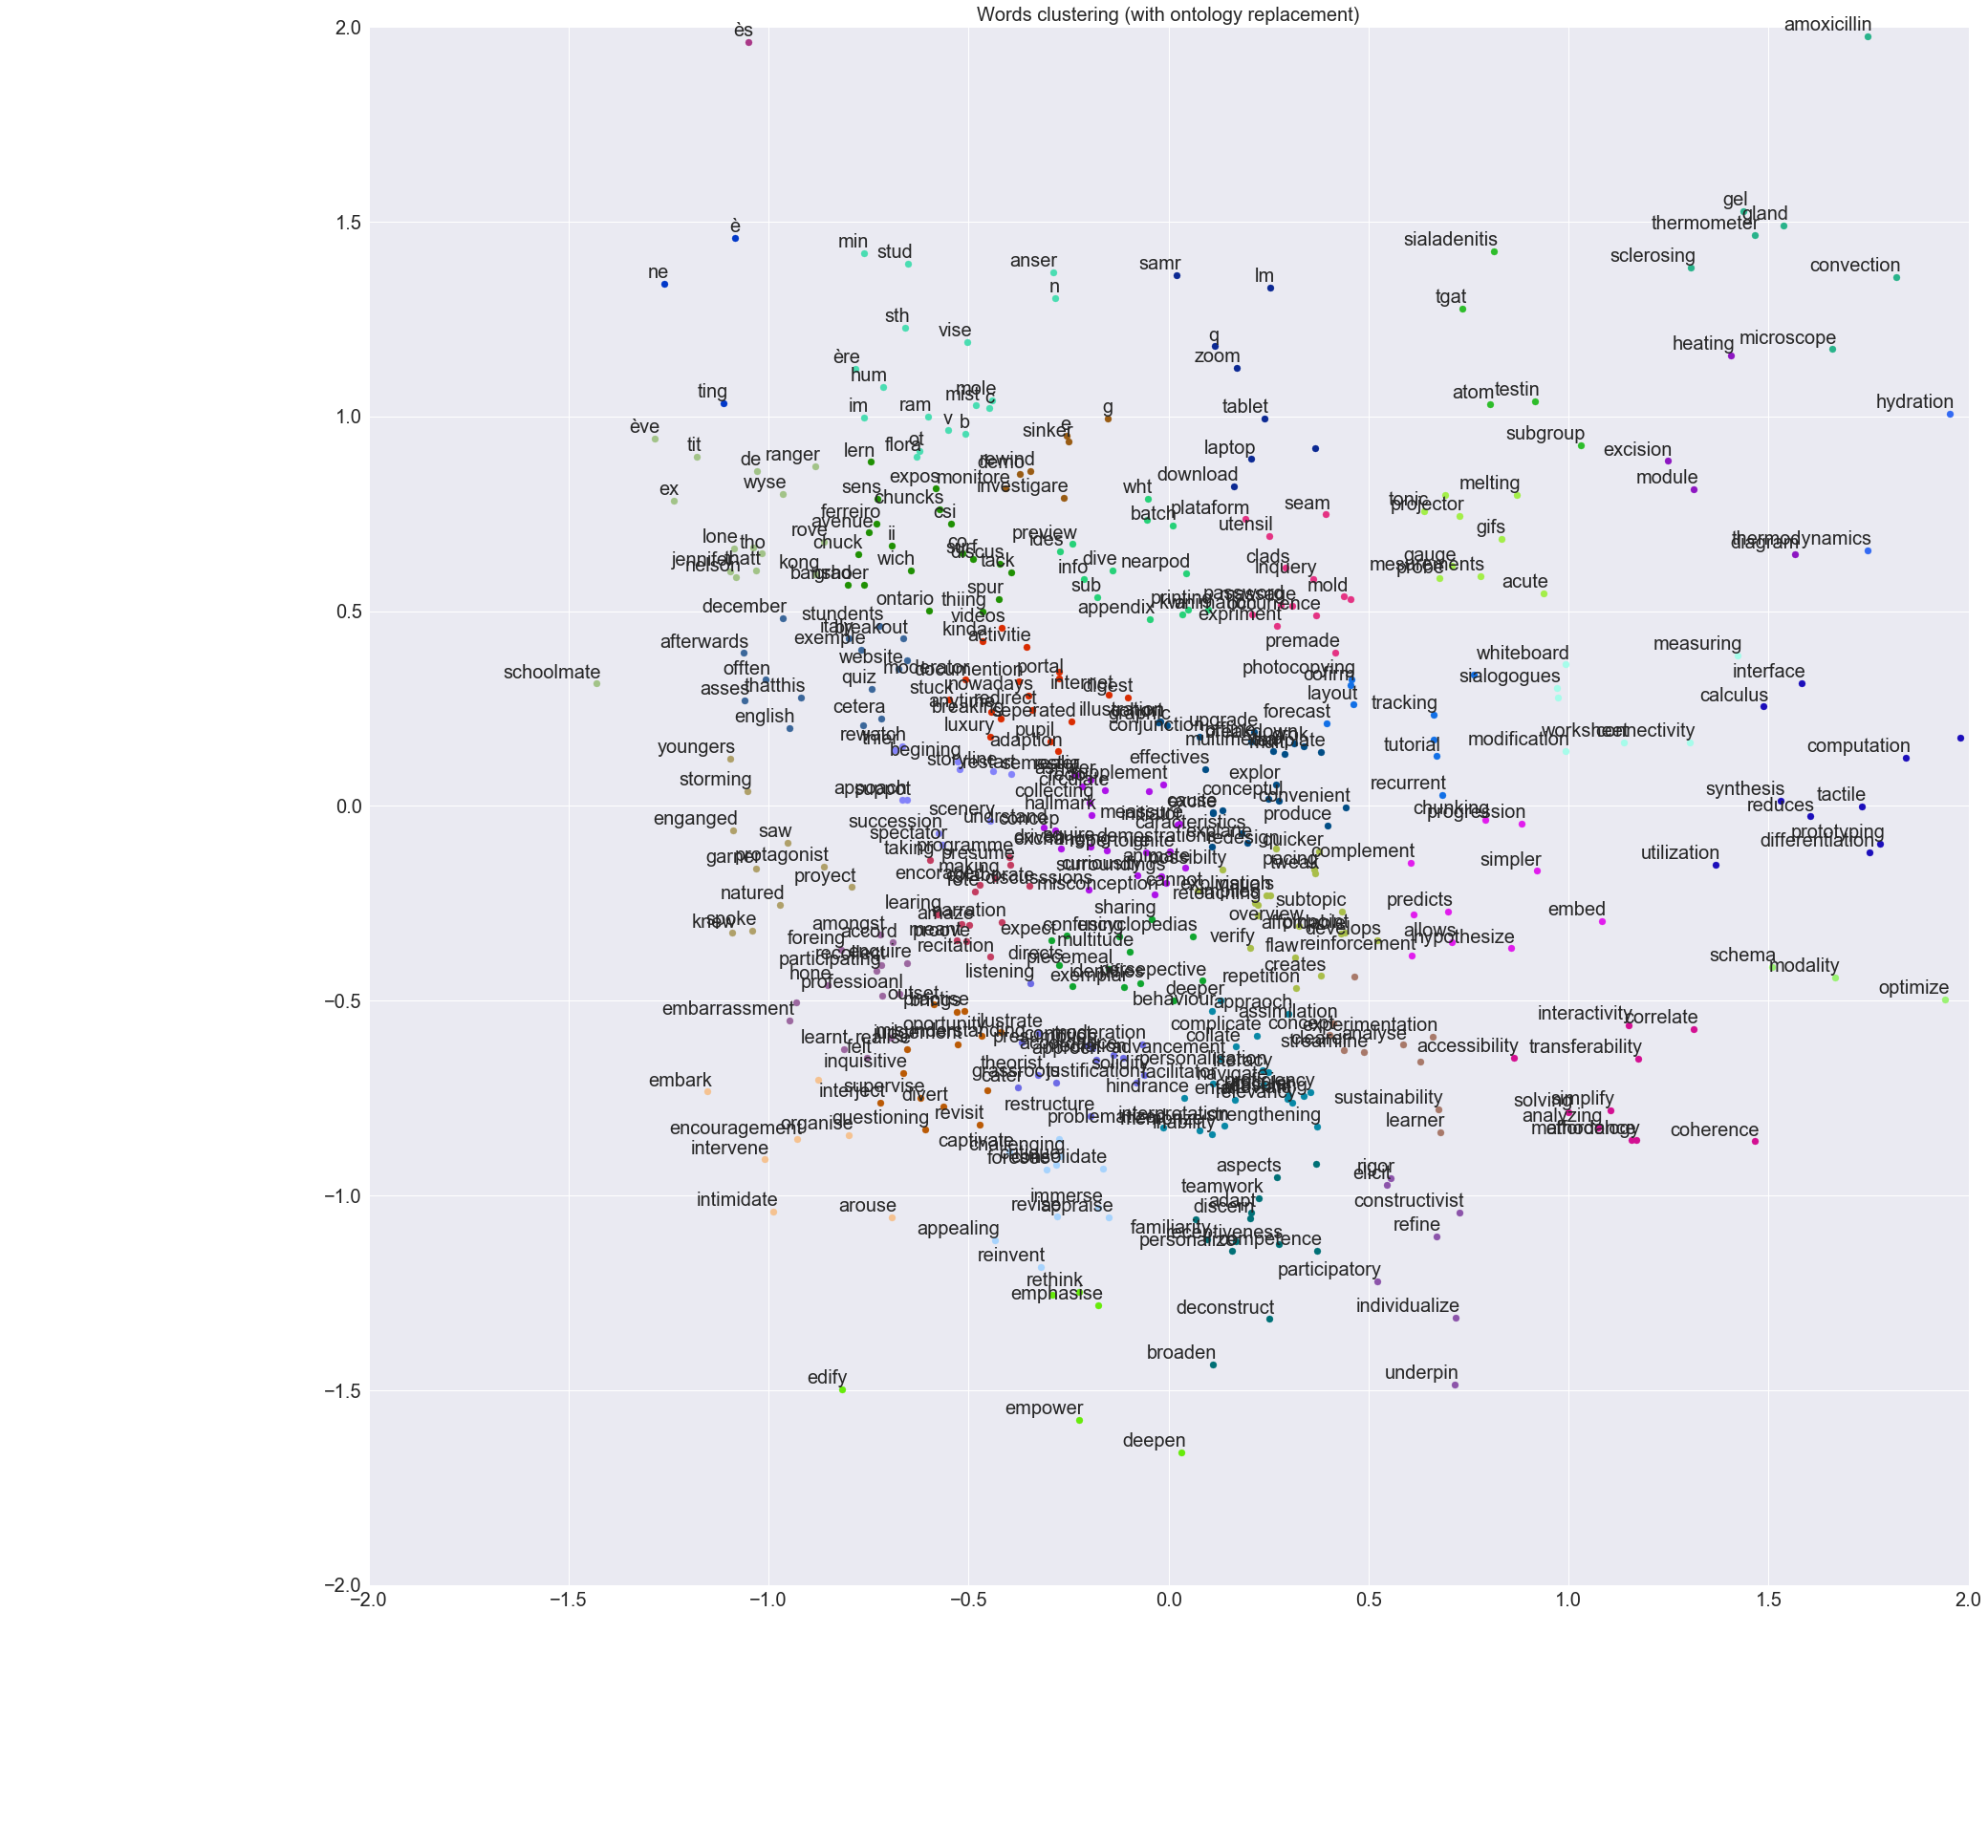

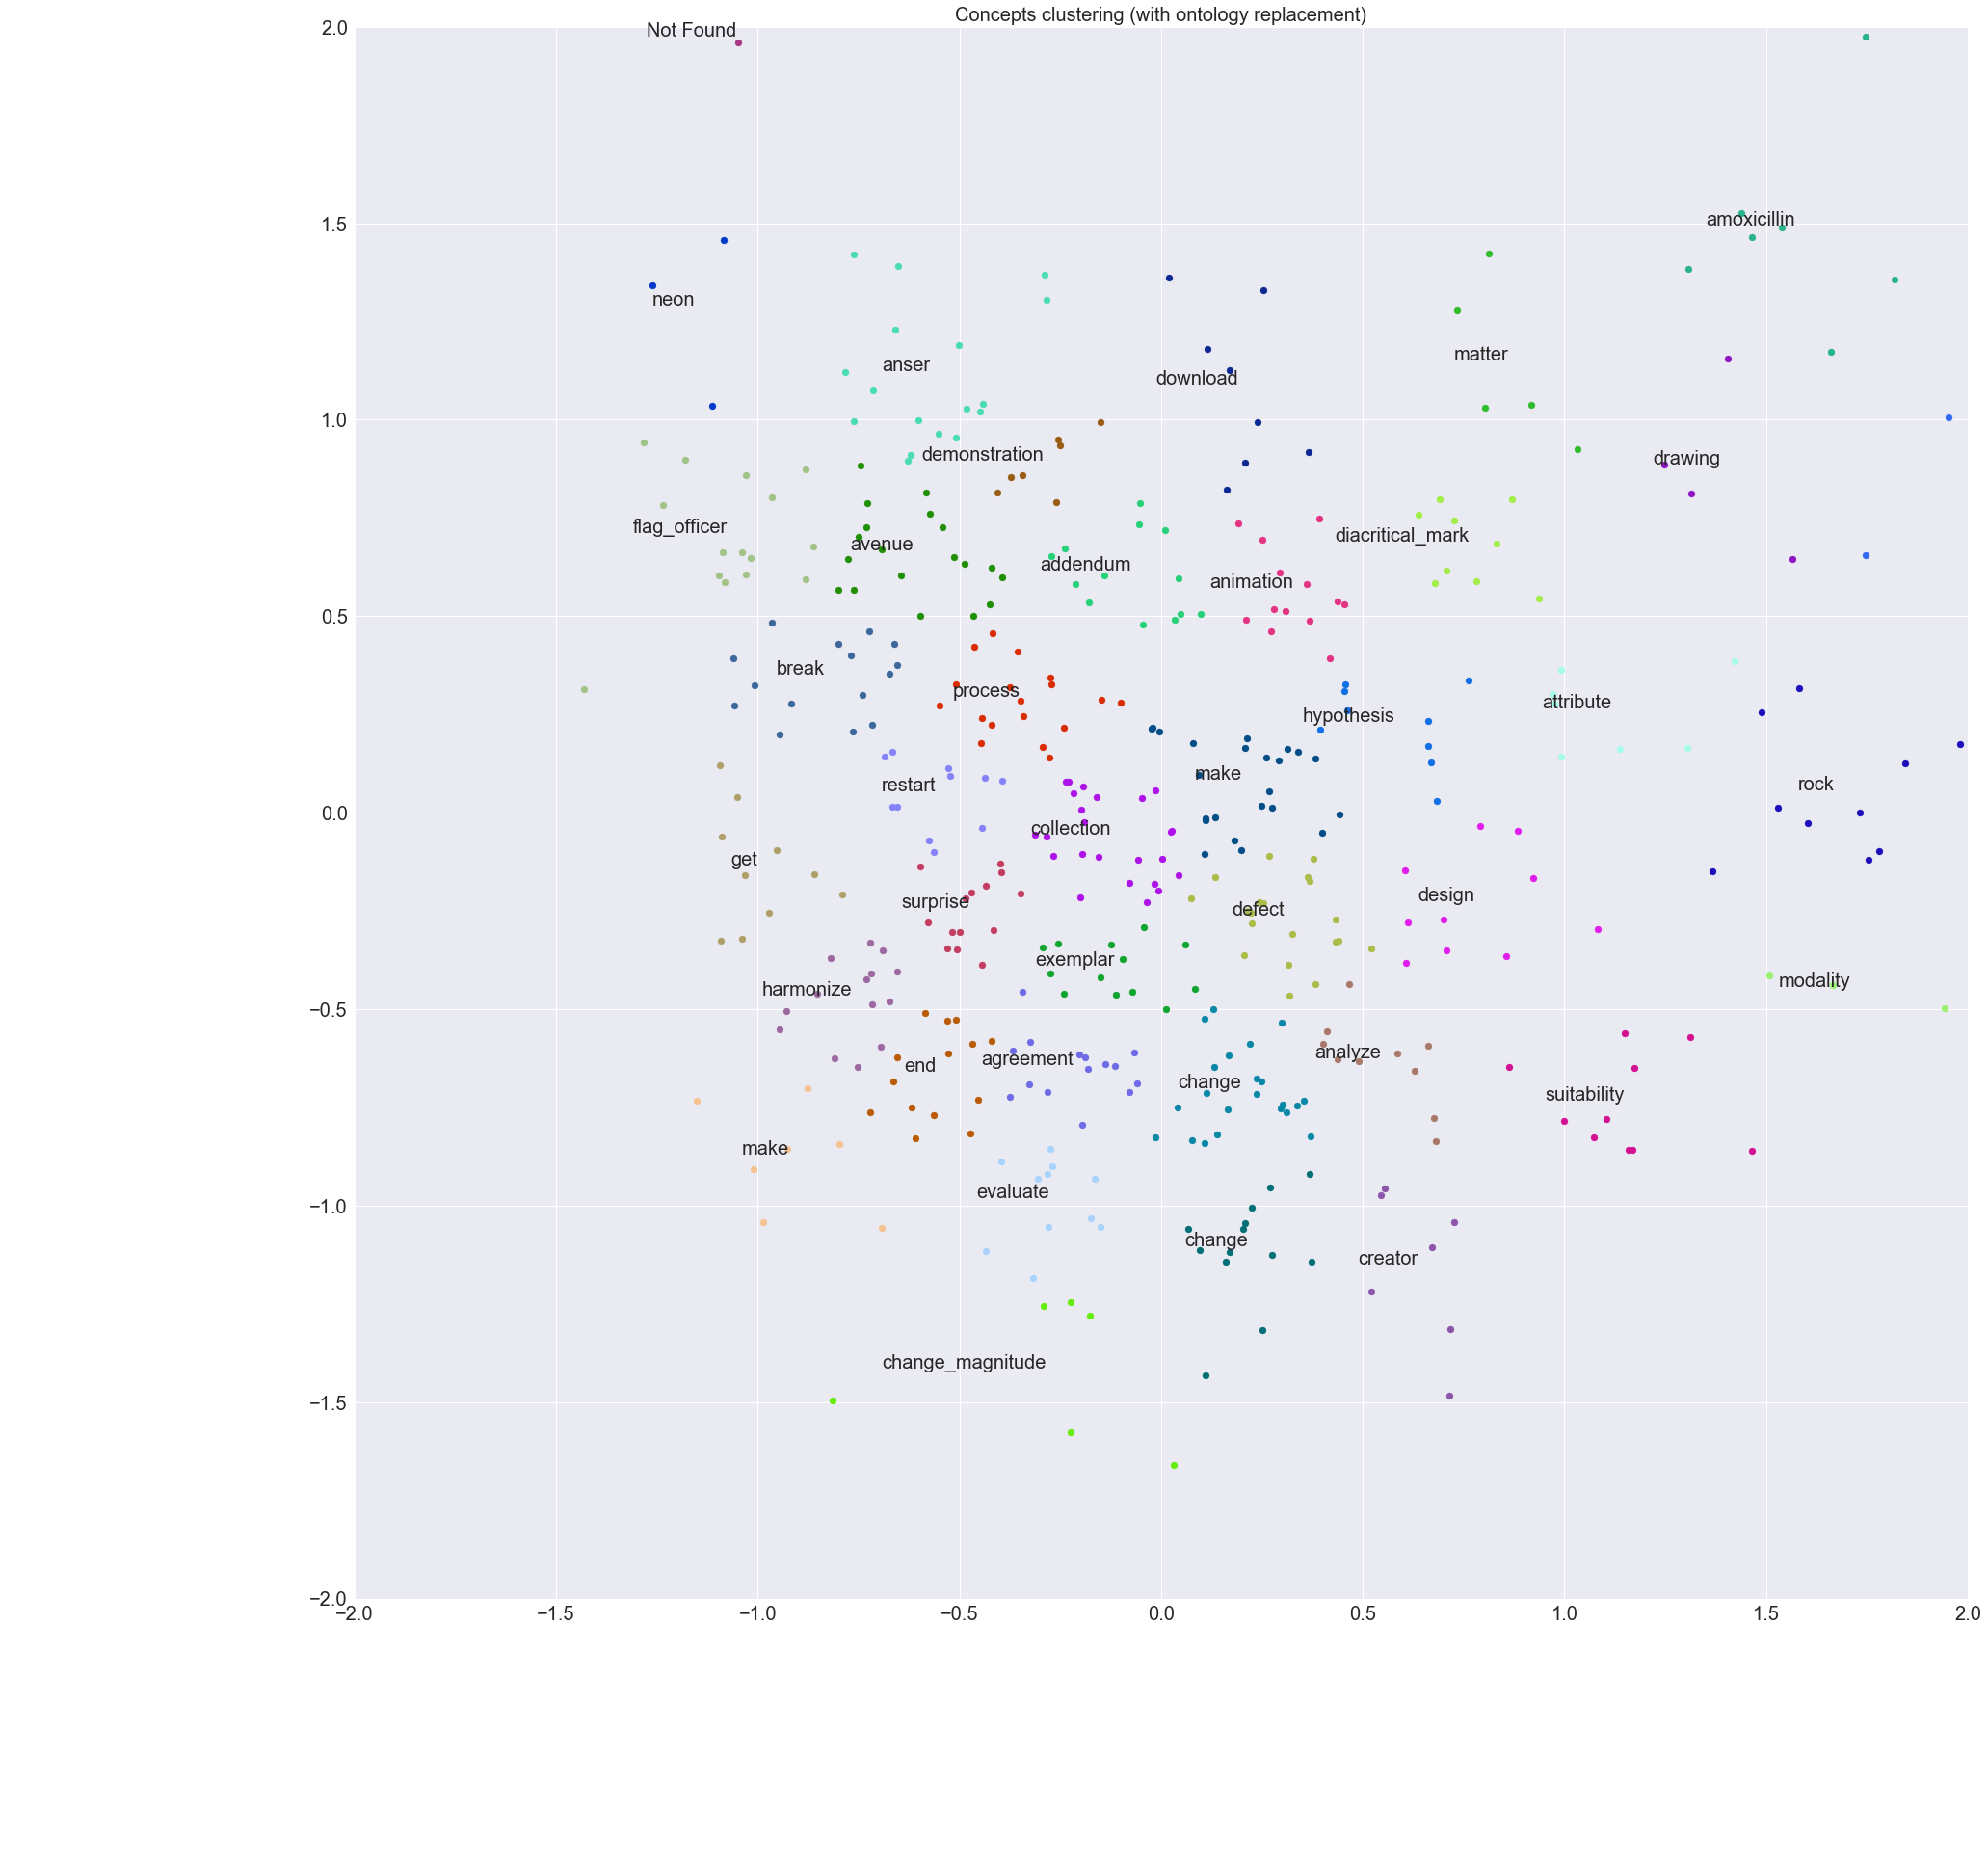

Finish
--------------------------------------
It took 1.8863240043322245 mins to run this method


In [518]:
now = time.time()

a, b, c, d = get_dashboard(PATH_STORE_DATA, 'text', k=40, threshold_replace= .7 , threshold_takeout=50,seed=SEED)


print('It took {s} mins to run this method'.format(s=(time.time()-now)/60))

In [443]:
a.head()

week                                               text language  \
0     1  The WISE simulations allowed the students to c...       en   
1     1  The most effective aspects in wise activity we...       en   
2     1  WISE uses predict-observe-explain patterns wit...       en   
3     1  It appears that the interactive app allowed th...       en   
4     1  Students can make predictions and test them. T...       en   

                                   standardized_text  \
0  the wise simulations allowed the students to c...   
1  the most effective aspects in wise activity we...   
2  wise uses predict observe explain patterns wit...   
3  it appears that the interactive app allowed th...   
4  students can make predictions and test them. t...   

                                      processed_text  
0  wise simulation allow student conceptualize ab...  
1  effective aspect wise activity create spirit t...  
2  wise use predict observe explain pattern promp...  
3  appear interactive app allow visualize science...  
4    student make prediction test work small group

In [444]:
b.head(30)

replaced_by                                         to_replace
0            cause                             [activate, activation]
1            cause                             [activate, activation]
2          enables                                  [allows, enables]
3      amoxicillin     [amoxicillin, clavulanate, clindamycin, nsaid]
4             drug                                 [analgesic, nsaid]
5   interpretation                           [clarification, clarify]
6   interpretation                           [clarification, clarify]
7       schoolmate                            [classmate, schoolmate]
8      clindamycin            [amoxicillin, clavulanate, clindamycin]
9      amoxicillin            [amoxicillin, clavulanate, clindamycin]
10        coherent                              [coherence, coherent]
11       coherence                              [coherence, coherent]
12    colaboration                         [colaborate, colaboration]
13      colaborate                         [colaborate, colaboration]
14          cooler                                   [colder, cooler]
15   collaborating                       [collaborate, collaborating]
16     collaborate                       [collaborate, collaborating]
17      competence                           [competence, competency]
18      competence                           [competence, competency]
19            grok                        [comprehend, comprehension]
20            grok                        [comprehend, comprehension]
21            make  [conceptualisation, conceptualise, conceptuali...
22         concept  [conceptualisation, conceptualise, conceptualize]
23         concept  [conceptualisation, conceptualise, conceptualize]
24      conduction                          [conductance, conduction]
25     conductance                          [conductance, conduction]
26      convection                                [convection, shear]
27          colder                                   [colder, cooler]
28         produce  [customise, customising, customizations, custo...
29         produce  [customise, customising, customizations, custo...

In [445]:
b.tail(30)

replaced_by                                         to_replace
37  experimentation                   [experimentation, experimenting]
38           expect                           [formulate, formulation]
39           expect                           [formulate, formulation]
40            gland                                 [gland, secretion]
41          enquire                                 [enquire, inquire]
42         learners                                [learner, learners]
43          learner                                [learner, learners]
44       memorizing                             [memorize, memorizing]
45         memorize                             [memorize, memorizing]
46      amoxicillin                    [amoxicillin, analgesic, nsaid]
47             hold                            [scaffold, scaffolding]
48             hold                            [scaffold, scaffolding]
49       schoolmate                            [classmate, schoolmate]
50            gland                                 [gland, secretion]
51       convection                                [convection, shear]
52          produce                 [simulate, simulating, simulation]
53          produce      [simulate, simulating, simulation, simulator]
54          produce      [simulate, simulating, simulation, simulator]
55   representation                [simulating, simulation, simulator]
56        subtopics                              [subtopic, subtopics]
57         subtopic                              [subtopic, subtopics]
58        synthesis                [synthesis, synthesise, synthesize]
59        synthesis                [synthesis, synthesise, synthesize]
60        synthesis                [synthesis, synthesise, synthesize]
61            adapt                                [tailor, tailoring]
62            adapt                                [tailor, tailoring]
63     visual_image  [conceptualisation, visualisation, visualise, ...
64   representation  [visualisation, visualise, visualization, visu...
65   representation  [visualisation, visualise, visualization, visu...
66   representation  [visualisation, visualise, visualization, visu...

In [470]:
c.head()

processed_text  count pos  \
0      abundance      1   n   
1  accessibility      1   n   
2         accord      8   v   
3     accordance      1   n   
4      activitie      1   n   

                                                vect          x          y  \
0  [-0.26207, 0.1481, -0.046696, 0.45521, 0.01820...   7.050398   8.852524   
1  [-0.0064332, 0.16794, 0.18712, 0.28707, -0.100...  -8.839286  14.965588   
2  [-0.098114, -0.24023, 0.15353, 0.31165, 0.0055...  14.269722  -0.540492   
3  [-0.33463, -0.25204, 0.023466, 0.20383, -0.089...  13.824831  -0.461686   
4  [-0.071888, -0.052625, -0.32589, -0.17648, -0....   9.253328  -1.896827   

   cluster                             cluster_center  x_cluster  y_cluster  \
0        6    [5.900516977213652, 10.091039467150694]  -1.173177   0.683470   
1        0   [-12.208873975276887, 16.10082804673823]  -0.523572  -1.774020   
2        8  [14.277929966554872, -0.3745824419891511]  -1.532501  -0.515743   
3        8  [14.277929966554872, -0.3745824419891511]  -1.556050  -0.523946   
4       30    [7.701763534032367, -3.120342149787131]   1.324056   1.711124   

   distance_to_center  representative_cluster      wordnet  
0            2.856147                   False       amount  
1           12.642894                   False  convenience  
2            0.027593                    True    harmonize  
3            0.212885                   False    harmonize  
4            3.904341                   False     breakage

In [448]:
c[c['cluster']==25]

processed_text  count pos  \
5            acute      1   n   
17     amoxicillin      5   n   
109  differentiate      7   v   
168          gland      3   n   
327      recurrent      1   n   
357     sclerosing      1   n   
364   sialadenitis      2   n   
365    sialogogues      1   n   
375    stimulation      4   n   
397        tactile      1   n   
402         testin      1   n   
415          tonic      1   n   

                                                  vect          x          y  \
5    [0.44446, -0.10784, -0.89487, 0.23077, -0.0779...  10.199767   9.676437   
17   [-0.12184, 0.34111, -0.78254, -0.29986, -0.705...  11.503816  12.893880   
109  [0.061734, 0.41202, -0.23505, 0.24325, -0.1235...   8.953720  14.170039   
168  [0.47001, -0.24935, -0.54961, 0.043446, -0.419...  13.906713   9.826464   
327  [0.14663, -0.10709, -0.38991, 0.30683, 0.12589...   9.648605  10.056186   
357  [0.30226, 0.025066, -0.58737, 0.32966, -0.3534...  11.656580  11.975239   
364  [-0.17772, -0.1212, -0.31711, 0.077607, -0.328...  12.209618  11.476847   
365  [0.248, 0.1043, -0.41554, 0.023288, -0.28678, ...  13.042538  12.014203   
375  [0.1945, 0.16925, -0.61623, 0.23274, -0.68142,...  13.558374   8.484758   
397  [0.03624, 0.39908, -0.31808, 0.30282, -0.19975...  12.252674   8.872282   
402  [0.32298, -0.10025, -0.4169, 0.0078349, -0.637...  13.857398  13.074226   
415  [0.29766, 0.1273, -0.4614, -0.13377, -0.28814,...  14.884532  11.784033   

     cluster                          cluster_center    x_cluster   y_cluster  
5         25  [12.1395279701106, 11.192049485931578]  -113.129295  262.457934  
17        25  [12.1395279701106, 11.192049485931578]  -327.753561   -6.587923  
109       25  [12.1395279701106, 11.192049485931578]   226.115663   92.207765  
168       25  [12.1395279701106, 11.192049485931578]   153.779870 -315.872643  
327       25  [12.1395279701106, 11.192049485931578]    64.810738  194.486777  
357       25  [12.1395279701106, 11.192049485931578] -1212.140784 -121.425905  
364       25  [12.1395279701106, 11.192049485931578]   492.718621  117.695420  
365       25  [12.1395279701106, 11.192049485931578]    14.048306  -39.776933  
375       25  [12.1395279701106, 11.192049485931578]   215.547343 -133.338640  
397       25  [12.1395279701106, 11.192049485931578]   388.961095  -55.721742  
402       25  [12.1395279701106, 11.192049485931578]   -63.158653 -320.450244  
415       25  [12.1395279701106, 11.192049485931578]   230.646440  334.943744

In [449]:
d.head()

processed_text  count pos  \
0      abundance      1   n   
1  accessibility      1   n   
2         accord      8   v   
3     accordance      1   n   
4      activitie      1   n   

                                                vect          x          y  \
0  [-0.26207, 0.1481, -0.046696, 0.45521, 0.01820...  -0.341938  -2.342984   
1  [-0.0064332, 0.16794, 0.18712, 0.28707, -0.100... -14.920953   2.255056   
2  [-0.098114, -0.24023, 0.15353, 0.31165, 0.0055...  -0.358530 -17.188664   
3  [-0.33463, -0.25204, 0.023466, 0.20383, -0.089...  -0.334213 -16.746028   
4  [-0.071888, -0.052625, -0.32589, -0.17648, -0....  12.673451  -0.537429   

   cluster                               cluster_center   x_cluster  \
0       29   [0.22286300661599429, -3.3318093200645165]  103.678798   
1       36    [-13.191532408751248, 3.8269469941642256]  132.016483   
2       10    [-0.2521606370026186, -13.98429489209478]   85.366307   
3       10    [-0.2521606370026186, -13.98429489209478]    9.112818   
4       11  [10.312688733264975, 0.0021125770869451985]  413.273996   

    y_cluster  
0 -209.556200  
1  358.154758  
2   10.457811  
3   31.872981  
4  165.378359

## 3.2) Detecting concepts + Create student groups
<a id='3.2'></a>

## 3.2.1) French dataset

In [198]:
french = pd.read_csv('data/data2.tsv', header = None, sep = '\t', encoding = "utf-8")
french.columns = ['text']
french.head(7)

text
0   On compte les clients du fitness qui viennent...
1  - Calculer le nombre d'étudiants libre dans ce...
2  -Un compteur à l’entrée qui permet de compter ...
3  -placer un portique qui laisse passer 1 person...
4  Afin d'estimer au mieux le nombre de personne,...
5  Afin de compter au mieux le nombre de personne...
6  AfinUne porte avec une carte permettrai de com...

In [176]:
def french_standardize_text(df, text_field):

    punctuations = ["/","(",")","\\","*","\'","&",">","=","≥","≤","|","\"", ":",",",";","?", "!", "[", "]", "{","}",'%','+','«','»']
    hours_re = "(?:\d{2}|\d{1})[a-zA-Z]" # remove 20h, 2h....
    nb_re = "\d+"                        #numbers
    
    new_text = []
    for text in df[text_field]:
        text = text.replace("\\n"," ").replace("\n", " ") \
                   .replace("\\r"," ").replace("-"," ") \
                   .replace("_"," ")

        text = re.sub(hours_re, " ", text)
        text = re.sub(nb_re   , " ", text)
        for x in punctuations:
            text = text.replace(x , " ")
        
        new_text.append(text.lower())
    
    df['standardized_' + text_field] = new_text

    return df

In [184]:
POS_JAR = "/Users/Cescnghia/Documents/dataset/stanford-postagger-full-2017-06-09/stanford-postagger-3.8.0.jar"
POS_MODEL = "/Users/Cescnghia/Documents/dataset/stanford-postagger-full-2017-06-09/models/french.tagger"

def get_french_pos(treebank_tag):
    """Map ['NN', 'NNS', 'NNP', 'NNPS'] to NOUN....."""
    if treebank_tag == 'ADJ':
        return wordnet.ADJ
    elif treebank_tag == 'ADV':
        return wordnet.ADV
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    else:
        return None


def french_processing_sentence(text, tokenizer, pos_tagger, lemmatizer, stop):
    "Tokenization"
    new_text = tokenizer.tokenize(text)
    "Lemmatization"
    tokens_pos = pos_tagger.tag(new_text)
    tokens_pos = [(w,get_french_pos(p)) for (w,p) in tokens_pos]
    new_text = [lemmatizer.lemmatize(w, pos=p) for (w,p) in tokens_pos if p != None]
    "Stopwords removing"
    new_text = [x for x in new_text if x not in stop]
    
    return new_text


def french_processing_text(df, text_field):
    tokenizer = RegexpTokenizer(r'\w+')
    pos_tagger = StanfordPOSTagger(POS_MODEL, POS_JAR, encoding='utf8' )
    lemmatizer = FrenchLefffLemmatizer()
    stop = stopwords.words('french')

    # Store processed original dataset
    new_text = []
    
    # Store normalized words (1-gram) and its POS
    words = []
    pos = []

    for text in df[text_field]: # a text may have multiple sentences
        new_sentences = ''
        for sentence in text.split('.'): # Treat one sentence at a time. Why ? because we're playing with POS
            processed_sentence = french_processing_sentence(sentence, tokenizer, pos_tagger, lemmatizer, stop)
            new_sentences += ' '.join(processed_sentence) + ' '
        new_text.append(new_sentences)
        
    df['processed_text'] = new_text
    
    return df

In [179]:
french.head()

text
0   On compte les clients du fitness qui viennent...
1  - Calculer le nombre d'étudiants libre dans ce...
2  -Un compteur à l’entrée qui permet de compter ...
3  -placer un portique qui laisse passer 1 person...
4  Afin d'estimer au mieux le nombre de personne,...

#### Scoring students' response 

In [185]:
now = time.time()

profAnswer = "Il faut utiliser la loi de poisson"
profAnswer += " ou poisson distribution"

french, french_sim_scores = check_responses(french, 'text', 20, profAnswer, english=False)

print('It took {s} mins to run this method'.format(s=(time.time()-now)/60))

/Users/Cescnghia/Applications/anaconda/lib/python3.6/site-packages/nltk/tag/stanford.py:149: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordPOSTagger, self).__init__(*args, **kwargs)


There are 161 responses in 634 significant terms


/Users/Cescnghia/Applications/anaconda/lib/python3.6/site-packages/nltk/tag/stanford.py:149: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordPOSTagger, self).__init__(*args, **kwargs)


It took 3.3238058129946393 mins to run this method


In [199]:
french_sim_scores

array([[ 1.        ,  0.14585266,  0.09697535, ...,  0.26371944,
         0.16486415,  0.00836816],
       [ 0.14585266,  1.        ,  0.14459777, ...,  0.52421649,
         0.01261812,  0.03941601],
       [ 0.09697535,  0.14459777,  1.        , ...,  0.36756242,
         0.7850708 ,  0.12778938],
       ...,
       [ 0.26371944,  0.52421649,  0.36756242, ...,  1.        ,
         0.29989871,  0.01702453],
       [ 0.16486415,  0.01261812,  0.7850708 , ...,  0.29989871,
         1.        , -0.01417982],
       [ 0.00836816,  0.03941601,  0.12778938, ...,  0.01702453,
        -0.01417982,  1.        ]])

In [186]:
french.head()

text  \
0   On compte les clients du fitness qui viennent...   
1  - Calculer le nombre d'étudiants libre dans ce...   
2  -Un compteur à l’entrée qui permet de compter ...   
3  -placer un portique qui laisse passer 1 person...   
4  Afin d'estimer au mieux le nombre de personne,...   

                                   standardized_text  \
0   on compte les clients du fitness qui viennent...   
1    calculer le nombre d étudiants libre dans ce...   
2   un compteur à l’entrée qui permet de compter ...   
3   placer un portique qui laisse passer   person...   
4  afin d estimer au mieux le nombre de personne ...   

                                      processed_text     score  
0  compter client fitness venir mardi heure an él... -0.411954  
1  calculer nombre étudiant libre intervalle temp...  0.657776  
2  compteur entrée permettre compter nombre perso... -0.220309  
3  placer portique laisser passer foi décompte no... -0.057414  
4  estimer mieux nombre falloir obliger personne ... -0.064776

In [187]:
french['score'].nlargest(10)

145    3.144488
146    3.144488
63     3.144488
42     3.060424
151    3.013987
77     2.706986
62     2.612488
87     2.503475
101    2.371651
109    1.611779
Name: score, dtype: float64

In [188]:
french.iloc[145]['text']

'loi poisson \\n'

In [331]:
for i in french['score'].nlargest(10).index:
    print('Response of student id',i,':')
    print("----->",french.iloc[i]['text'])
    print('#############################')

Response of student id 63 :
-----> Loi poisson.
#############################
Response of student id 146 :
-----> loi poisson\n\n\n\n\n\n\n\n\n\n\n\n\n
#############################
Response of student id 145 :
-----> loi poisson \n
#############################
Response of student id 42 :
-----> Il s agit de la loi poisson.\n
#############################
Response of student id 151 :
-----> on utilise la Loi  De Poisson , on determine le nombre moyen de personnes entrant par heure pour cela on réalise un comptage sur un mois d'ouverture 
#############################
Response of student id 62 :
-----> Loi de poisson sur les nombre de visite par 2 heures dans le centre sportif, adapté à 
#############################
Response of student id 77 :
-----> Moyenne des entrées par heure fois 2\n\n->loi de Poisson\n
#############################
Response of student id 87 :
-----> On compte le nombre de personne qui arrivent de 17h à 19h. Graçe à l'utilisation de carte magnétique on trouve que

#### Create students' group

In [340]:
nbResponse, nbResponse = french_sim_scores.shape

print('Top 5 responses similarity for each student')
for i in range(nbResponse):
    print('Student ' + str(i) +': ')
    student_score = french_sim_scores[i]
    argmax_ = student_score.argsort()[::-1][:5]
    for j in argmax_:
        print('-------Student ' + str(j) +' with score: '+str(student_score[j]))

Top 5 responses similarity for each student
Student 0: 
-------Student 0 with score: 1.0
-------Student 115 with score: 0.8024906286586403
-------Student 23 with score: 0.5663102303078733
-------Student 32 with score: 0.5328955832494522
-------Student 100 with score: 0.4885439921846539
Student 1: 
-------Student 1 with score: 1.0000000000000002
-------Student 8 with score: 0.7216542560405279
-------Student 141 with score: 0.6373855462383277
-------Student 33 with score: 0.6249276776917606
-------Student 36 with score: 0.6215675714570558
Student 2: 
-------Student 2 with score: 1.0000000000000002
-------Student 76 with score: 0.9146252658689321
-------Student 112 with score: 0.897428534846404
-------Student 70 with score: 0.8286621858603671
-------Student 159 with score: 0.784611923584905
Student 3: 
-------Student 3 with score: 1.0000000000000002
-------Student 117 with score: 0.8395988133003349
-------Student 135 with score: 0.6709860740916401
-------Student 110 with score: 0.64876049

##### These students want to use Poisson distribution

In [336]:
french.iloc[63]['text']

'Loi poisson.'

In [337]:
french.iloc[146]['text'] 

'loi poisson\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n'

In [338]:
french.iloc[145]['text']

'loi poisson \\n'

In [339]:
french.iloc[42]['text']

'Il s agit de la loi poisson.\\n'

In [341]:
french.iloc[77]['text']

'Moyenne des entrées par heure fois 2\\n\\n->loi de Poisson\\n'

##### These students want to do some statistics

In [226]:
french.iloc[31]['text']

"Faire des observations chaque mardi entre 17h et 19h, faire la moyenne de ces observation et aussi l'écart type\\n"

In [227]:
french.iloc[100]['text']

'On peut faire plusieurs observation et faire une moyenne du nombre de personnes venant de 17 à 19h.'

In [228]:
french.iloc[141]['text']

"faire une statistique sur un an, en faisant une médiane.\\nA cela il faut ajouter l'équart type pour interpreter l'équart à la moyenne"

In [236]:
french.iloc[14]['text']

"Collecter les données sur plusieurs mardis, calculer la moyenne, la médiane, l'écart type"

##### These students have different ideas

In [237]:
print('Top 5 responses DISimilarity for each student')
for i in range(nbResponse):
    print('Student ' + str(i) +': ')
    student_score = french_sim_scores[i]
    argmax_ = student_score.argsort()[:5]
    for j in argmax_:
        print('-------Student ' + str(j) +' with score: '+str(student_score[j]))

Top 5 responses similarity for each student
Student 0: 
-------Student 139 with score: -0.21308376591927794
-------Student 132 with score: -0.20080225317862263
-------Student 48 with score: -0.19370775481003166
-------Student 50 with score: -0.19215625100548894
-------Student 103 with score: -0.18154257957611497
Student 1: 
-------Student 136 with score: -0.15692646443259245
-------Student 130 with score: -0.1562263543446329
-------Student 89 with score: -0.15345320223423714
-------Student 28 with score: -0.09152013200022618
-------Student 160 with score: -0.06959701619582433
Student 2: 
-------Student 137 with score: -0.2088542164235426
-------Student 52 with score: -0.11032818394561635
-------Student 106 with score: -0.10499848615912834
-------Student 84 with score: -0.0992806808281235
-------Student 25 with score: -0.08993607796114717
Student 3: 
-------Student 130 with score: -0.29208003376604713
-------Student 57 with score: -0.27289041975876865
-------Student 56 with score: -0.26

In [241]:
scores.iloc[84]['text']

'On calcule la distribution de probabilité grâce à l’esperance Et la variance\\n'

In [242]:
scores.iloc[29]['text']

'Estimer le nombre de personnes entrant dans le centre sportif, les autres jours de la semaine puis estimer le pic de fréquentation.\\n\\nEnsuite extrapoler la fréquentation du mardi.'

In [243]:
scores.iloc[143]['text']

'je sonderais les clients du centre sportif quant à leur fréquentation hebdomadaire du centre sportif et à partir des résultats obtenus, je peux évaluer plus ou moins quel est le taux de fréquentation du centre sportif le mardi entre 17h et 19h'

## 3.2.2) Reflection dataset

In [201]:
"""
    Reflection data set preparation:
     - Week: 1, question number 1
"""

ref_w1q1 = select_sub_responses(ref, week = 1, num = 1)
ref_w1q1.head()

week                                               text language
0     1  The WISE simulations allowed the students to c...       en
1     1  The most effective aspects in wise activity we...       en
2     1  WISE uses predict-observe-explain patterns wit...       en
3     1  It appears that the interactive app allowed th...       en
4     1  Students can make predictions and test them. T...       en

In [194]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds
#from french_prerpocessing import french_preprocessing_text

def response_term_similarity(u, S, v_t):
    """
      Similarity between a response and term in concept space.
      (We apply SVD algorithm to original matrix X.)
      Here `u`   is a representation of a response in concept space
           `v_t` is a representation of a term in concept space
            S     is sigular values of X
    """
    temp = np.diag(S) @ v_t
    return np.dot(u, temp) / np.sqrt(np.sum(u ** 2) * np.sum(temp **2))

def response_response_similarity(resp1, resp2, S):
    resp1_ = np.diag(S) @ resp1
    resp2_ = np.diag(S) @ resp2
    
    return np.dot(resp1_, resp2_) / np.sqrt(np.sum(resp1_ ** 2) * np.sum(resp2_ ** 2))



def check_responses(df, text_field, latentSpace, yourConcept, english=True):

    ##############PREPROCESSING TEXT##############
    "Create a dataframe from yourConcept and concatenate with df"
    NB_REPLICATE = 10
    df_concept = pd.DataFrame([yourConcept] * NB_REPLICATE, columns=[text_field])
    df = pd.concat([df, df_concept]).reset_index().drop('index', 1)
    if (english):
        df = standardize_text(df, text_field)
        df, _ = processing_text(df, 'standardized_text')
    else:
        df = french_standardize_text(df, text_field)
        df = french_processing_text(df, 'standardized_text')
    
    "Students' response scores"
    response_scores = {}
    
    "Compute TFIDF matrix"
    tfidf_vec = TfidfVectorizer()
    tfidf = tfidf_vec.fit_transform(df['processed_text'])
    vocab = tfidf_vec.get_feature_names()
    
    tfidf = tfidf[:-NB_REPLICATE]
    df = df[:-NB_REPLICATE].reset_index().drop('index', 1)
    
    nbResponse, nbTerm = tfidf.shape
    print('There are {r} responses in {t} significant terms'.format(r=nbResponse,t=nbTerm))
    
    "apply SVD to TFIDF matrix"
    U, S, V_T = svds(tfidf, k=latentSpace)
    
    "Preprocessed yourConcept"
    tokenizer = RegexpTokenizer(r'\w+')
    if (english):
        lemmatiser = WordNetLemmatizer()
        stop = stopwords.words('english')
        tokens_pos, concepts = english_processing_sentence(yourConcept, tokenizer, lemmatiser, stop)
    else:
        pos_tagger = StanfordPOSTagger(POS_MODEL, POS_JAR, encoding='utf8' )
        lemmatiser = FrenchLefffLemmatizer()
        stop = stopwords.words('french')
        concepts = french_processing_sentence(yourConcept, tokenizer, pos_tagger, lemmatiser, stop)
    
    print(concepts)
    scores = []
    "Compute score for each responses"
    for response in range(nbResponse):
        score = 0.0
        for concept in concepts:
            try:
                concept_idx = vocab.index(concept)
            except:
                continue
                
            u = U[response]
            v = V_T.T[concept_idx]
            score += response_term_similarity(u, S, v)
        scores.append(score)
        
    df['score'] = scores
    
    
    "Compute students' similarity score"
    
    sim_scores = np.zeros((nbResponse,nbResponse))
    
    for row in range(nbResponse):
        for col in range(row + 1):
            resp1 = U[row]
            resp2 = U[col]
            score = response_response_similarity(resp1, resp2, S)
            sim_scores[row, col] = score
            sim_scores[col, row] = score
    
    
    return df, sim_scores

In [200]:
# -*- coding: utf-8 -*-

import nltk
from nltk import pos_tag
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import wordnet, stopwords
import re
import pandas as pd
import numpy as np


def standardize_text(df, text_field):
    
    """ 
        Input:
            - df: data's dataframe
            - text_field: column's (row of string) name that we want to standardize
        Output:
            - dataframe contains column `standardized`
    """
    
    urls_re = r'http\S+' #urls
    ht_re = r'#\S+'      #hashtags
    at_re = r'@\S+'      #@
    nb_re = " \d+"       #numbers

    punctuations = ["/","(",")","\\","|", ":",",",";","?", "!", "[", "]", "{","}"]
    
    new_text = []
    for text in df[text_field]:
        
        text = text.replace("\\n"," ").replace("\n", " ").replace("\\r"," ").replace("-"," ").replace("_"," ")
        
        for x in punctuations:
            text = text.replace(x , " ")
            
        text = re.sub(urls_re , " ", text)
        text = re.sub(ht_re   , " ", text)
        text = re.sub(at_re   , " ", text)
        text = re.sub(nb_re   , " ", text)
        
        text = text.replace("http"," ")
        
        new_text.append(text.lower())
    
    df['standardized_' + text_field] = new_text

    return df

def get_wordnet_pos(treebank_tag):
    """Map ['NN', 'NNS', 'NNP', 'NNPS'] to NOUN....."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def english_processing_sentence(sentence, tokenizer, lemmatiser, stop):
    "Tokenization"
    new_sentence = tokenizer.tokenize(sentence)
    "Lemmatization"
    tokens_pos = pos_tag(new_sentence)
    tokens_pos = [(w,get_wordnet_pos(p)) for (w,p) in tokens_pos]
    new_sentence = [lemmatiser.lemmatize(w, pos=p) for (w,p) in tokens_pos if p != None]
    "Stopwords removing"
    new_sentence = [x for x in new_sentence if x not in stop]

    return tokens_pos, new_sentence

def processing_text(df, text_field):
    
    """
        Input : 
            - Dataframe with the column's name (each row is a string) we want to process 
        Output:
            - One dataframe contains the processed original text
            - One dataframe in which each row is a 1-gram word (normalized word)
    """

    tokenizer = RegexpTokenizer(r'\w+')
    lemmatiser = WordNetLemmatizer()
    stop = stopwords.words('english')

    # Store processed original text
    new_text = []
    
    # Store normalized word (1-gram) and its parts of speech
    #original_words = []
    words = []
    pos = []
    
    for text in df[text_field]: # text may have multiple sentences
        new_sentences = ''
        for sentence in text.split('.'): # One sentence at a time (because we're playing with POS)
            
            tokens_pos, new_sent = english_processing_sentence(sentence, tokenizer, lemmatiser, stop)

            new_sentences += ' '.join(new_sent)
            new_sentences += ' '

            for (w, p) in tokens_pos:
                if (p == 'v' or p == 'n'):
                    word = lemmatiser.lemmatize(w, pos=p)
                    if word not in stop:
                        words.append(word)
                        pos.append(p)
                        #original_words.append(w)
        new_text.append(new_sentences)
    
    df['processed_text'] = new_text
    
    "Construct dataframe for each word, its count, its POS"
    df_normalised = pd.DataFrame({'processed_text': words, 'pos':pos})
    a = df_normalised.groupby(['processed_text']).agg('count')
    a = a.reset_index()
    a.columns = ['processed_text', 'count']
    b = df_normalised.drop_duplicates('processed_text')
    df_normalised = pd.merge(a, b, on='processed_text', how='outer')
    
    return df, df_normalised

#### Scoring students' response 

In [202]:
now = time.time()

profAnswer = "experiment melt chocolate"
profAnswer += ""
ref_w1q1, english_sim_scores = check_responses(ref_w1q1, 'text', 60, profAnswer)

print('It took {s} mins to run this method'.format(s=(time.time()-now)/60))

There are 733 responses in 2040 significant terms
['experiment', 'melt', 'chocolate']
It took 0.16419850587844848 mins to run this method


In [204]:
english_sim_scores

array([[1.        , 0.17584918, 0.38501314, ..., 0.13001551, 0.17873182,
        0.05850435],
       [0.17584918, 1.        , 0.3723515 , ..., 0.09410064, 0.00336194,
        0.1875853 ],
       [0.38501314, 0.3723515 , 1.        , ..., 0.18109163, 0.07505404,
        0.20159956],
       ...,
       [0.13001551, 0.09410064, 0.18109163, ..., 1.        , 0.0719275 ,
        0.14894327],
       [0.17873182, 0.00336194, 0.07505404, ..., 0.0719275 , 1.        ,
        0.26394109],
       [0.05850435, 0.1875853 , 0.20159956, ..., 0.14894327, 0.26394109,
        1.        ]])

In [203]:
ref_w1q1.head()

language                                               text  week  \
0       en  The WISE simulations allowed the students to c...   1.0   
1       en  The most effective aspects in wise activity we...   1.0   
2       en  WISE uses predict-observe-explain patterns wit...   1.0   
3       en  It appears that the interactive app allowed th...   1.0   
4       en  Students can make predictions and test them. T...   1.0   

                                   standardized_text  \
0  the wise simulations allowed the students to c...   
1  the most effective aspects in wise activity we...   
2  wise uses predict observe explain patterns wit...   
3  it appears that the interactive app allowed th...   
4  students can make predictions and test them. t...   

                                      processed_text     score  
0  wise simulation allow student conceptualize ab...  0.195090  
1  effective aspect wise activity create spirit t... -0.174336  
2  wise use predict observe explain pattern promp...  0.052137  
3  appear interactive app allow visualize science... -0.122907  
4    student make prediction test work small group    0.037547

In [314]:
for i in ref_w1q1['score'].nlargest(10).index:
    print('Response of student id',i,':')
    print("----->",ref_w1q1.iloc[i]['text'])
    print('#############################')

Response of student id 170 :
-----> I think the area where students explored in melting chocolate chips and touching an iron with different bars made of glass and metal really gave a huge understanding to the students. 
#############################
Response of student id 414 :
-----> 1.  They felt the objects by themselves\r\n2.   They melted chocolate bars on hot iron and glass\r\n3.   They got to know why heat transported more quickly through some more than others
#############################
Response of student id 347 :
-----> - Breaking the topic down into small, manageable pieces\r\n- providing simulations that were concrete and within the students' realm of experience (e.g. The hot iron heating different surfaces to melt chocolate chips)\r\n- providing a classroom / real world opportunity to physically engage in topic material (e.g. Touching classroom objects & checking their temperatures)
#############################
Response of student id 672 :
-----> I think the visual simu

#### Create students' group

In [267]:
nbResponse, nbResponse = english_sim_scores.shape

print('Top 5 responses similarity for each student')
for i in range(nbResponse):
    print('Student ' + str(i) +': ')
    student_score = english_sim_scores[i]
    argmax_ = student_score.argsort()[::-1][:5]
    for j in argmax_:
        print('-------Student ' + str(j) +' with score: '+str(student_score[j]))

Top 5 responses similarity for each student
Student 0: 
-------Student 0 with score: 1.0
-------Student 661 with score: 0.5911773790486857
-------Student 6 with score: 0.5108217483223906
-------Student 302 with score: 0.4982569566371116
-------Student 729 with score: 0.47711779839249374
Student 1: 
-------Student 1 with score: 1.0
-------Student 350 with score: 0.8007088944297958
-------Student 584 with score: 0.7489880451446266
-------Student 65 with score: 0.6992666528249626
-------Student 478 with score: 0.682932971255225
Student 2: 
-------Student 2 with score: 1.0000000000000002
-------Student 49 with score: 0.6217838982012259
-------Student 504 with score: 0.5869788065018618
-------Student 613 with score: 0.5528099531444169
-------Student 207 with score: 0.49575938955804144
Student 3: 
-------Student 3 with score: 1.0
-------Student 610 with score: 0.6634136891106271
-------Student 293 with score: 0.49940391269204154
-------Student 479 with score: 0.4494451269773779
-------Studen

##### Their answers seem ...similar

In [342]:
ref_w1q1.iloc[49]['text']

'As explained in the video, the students are encouraged to investigate, measure, and think about the possible explanations...rather than simply telling them the right answer.'

In [343]:
ref_w1q1.iloc[504]['text']

"\x8a\x97¢  Pupils collaborate with partners.\\r\\n\x8a\x97¢  Students can test their predictions and use simulations.\\r\\n\x8a\x97¢ Wise activities don't just try to tell the kids the right answer, but rather they encourage them to investigate, measure, and think about the possible explanations.\\r\\n"

In [344]:
ref_w1q1.iloc[207]['text']

"The Wise program doesn't just try to tell students the right answer, but rather encourages them to investigate, measure, and think about the possible explanations.  It also allows the instructor the opportunity to track progress in real time and provide comments/feedback. "

##### Their answers seem ...similar

In [345]:
ref_w1q1.iloc[60]['text']

'WISE helps break down concepts into very small, manageable pieces, and then it helps the students, and encourage them to build the ideas. '

In [346]:
ref_w1q1.iloc[671]['text']

'The demostrations she did to students with the WISE activity, breaking down concepts\\r\\ninto very small, manageable pieces,  helping students to build ideas up for an easier comprehension\\r\\n'

In [347]:
ref_w1q1.iloc[209]['text']

'WISE activity breaks down concepts into very small, manageable pieces, and then it helps the students, scaffolds them, to kind of build those ideas up to a more coherent understanding.'

In [348]:
ref_w1q1.iloc[534]['text']

'WISE activity breaks down concepts into very small, manageable pieces, and then it helps the students, scaffolds them, to kind of build those ideas up to a more coherent understanding.\\r\\n'

### Check similarity for english dataset using Tensorflow Hub

In [350]:
import tensorflow as tf
import tensorflow_hub as hub

In [351]:
def hub_sentence_embeddings(sentences):

    with tf.Graph().as_default():
        embed = hub.Module("https://tfhub.dev/google/nnlm-en-dim128-with-normalization/1")
        embeddings = embed(sentences)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.tables_initializer())

            return sess.run(embeddings)

In [361]:
sentences = ["The university should invest in solar cell panels", 
             "We should all walk more", 
             "The school should reduce it's electricity comsumption",
             "We should use our bicycles more"]

embedded = sentence_embeddings([x for x in ref_w1q1['processed_text']])

INFO:tensorflow:Initialize variable module/embeddings/part_0:0 from checkpoint b'/var/folders/6l/0zt406zd3v1c3jv20lqlkpmc0000gn/T/tfhub_modules/2cdbcae1a547f4fb93475d4b7d4140f8590995b7/variables/variables' with embeddings


In [ ]:
embedded = sentence_embeddings([x for x in ref_w1q1['processed_text']])
english_sim_scores_by_tensorhub = cosine_similarity(embedded)

In [362]:
embedded.shape

(733, 128)

In [363]:
english_sim_scores_by_tensorhub = cosine_similarity(embedded)

In [364]:
english_sim_scores_by_tensorhub

array([[0.99999994, 0.8120347 , 0.7931539 , ..., 0.79546165, 0.43717366,
        0.73261446],
       [0.8120347 , 1.        , 0.78195477, ..., 0.7806645 , 0.43387267,
        0.7525393 ],
       [0.7931539 , 0.78195477, 1.0000002 , ..., 0.6539694 , 0.4640161 ,
        0.6667055 ],
       ...,
       [0.79546165, 0.7806645 , 0.6539694 , ..., 0.99999994, 0.47890535,
        0.79023576],
       [0.43717366, 0.43387267, 0.4640161 , ..., 0.47890535, 1.        ,
        0.4157381 ],
       [0.73261446, 0.7525393 , 0.6667055 , ..., 0.79023576, 0.4157381 ,
        0.9999999 ]], dtype=float32)

In [365]:
nbResponse, nbResponse = english_sim_scores_by_tensorhub.shape

print('Top 5 responses similarity for each student')
for i in range(nbResponse):
    print('Student ' + str(i) +': ')
    student_score = english_sim_scores_by_tensorhub[i]
    argmax_ = student_score.argsort()[::-1][:5]
    for j in argmax_:
        print('-------Student ' + str(j) +' with score: '+str(student_score[j]))

Top 5 responses similarity for each student
Student 0: 
-------Student 0 with score: 0.99999994
-------Student 244 with score: 0.8828831
-------Student 613 with score: 0.880403
-------Student 173 with score: 0.8787782
-------Student 302 with score: 0.87569034
Student 1: 
-------Student 1 with score: 1.0
-------Student 390 with score: 0.91345584
-------Student 613 with score: 0.9123889
-------Student 54 with score: 0.905751
-------Student 531 with score: 0.90389174
Student 2: 
-------Student 2 with score: 1.0000002
-------Student 266 with score: 0.81959903
-------Student 49 with score: 0.8121025
-------Student 448 with score: 0.80851436
-------Student 350 with score: 0.80700403
Student 3: 
-------Student 3 with score: 0.9999999
-------Student 561 with score: 0.8514553
-------Student 535 with score: 0.8294858
-------Student 302 with score: 0.8288391
-------Student 115 with score: 0.82772577
Student 4: 
-------Student 4 with score: 1.0000002
-------Student 411 with score: 0.8969439
------

In [366]:
ref_w1q1.iloc[49]['text']

'As explained in the video, the students are encouraged to investigate, measure, and think about the possible explanations...rather than simply telling them the right answer.'

In [367]:
ref_w1q1.iloc[504]['text']

"\x8a\x97¢  Pupils collaborate with partners.\\r\\n\x8a\x97¢  Students can test their predictions and use simulations.\\r\\n\x8a\x97¢ Wise activities don't just try to tell the kids the right answer, but rather they encourage them to investigate, measure, and think about the possible explanations.\\r\\n"

In [368]:
ref_w1q1.iloc[207]['text']

"The Wise program doesn't just try to tell students the right answer, but rather encourages them to investigate, measure, and think about the possible explanations.  It also allows the instructor the opportunity to track progress in real time and provide comments/feedback. "

In [371]:
ref_w1q1.iloc[54]['text']

'The WISE activity allows students to reflect on various scenarios, work collaboratively with peers and encourage them to investigate, measure and think of their explanations as they learn to make connections from their experience to the new ideas.  The WISE activity brings diverse experiences, perspectives, knowledge and skills to students\x8a\x97È learning.  With the support of technology, students can visualize their learning. They become engaged learners who are active in their learning which helps students reach their full learning potential. '

In [372]:
ref_w1q1.iloc[613]['text']

"I realize that reflect on various scenarios, collaborate with partners, make and test the possibilities, use simulations to compare, predict, give meaning to the concepts and approach the student's knowledge through the possible combinations that this activity has at WISE. Not only information transmitted to the students, the WISE enables knowledge is presented in a concrete way for the student, which can assist students in learning through associations, which seems to me fundamental. Also the fact after the simulations can touch the objects involved and experience the situation transformed the experience and probably the concepts have greater meaning. Transform our students into research must be one of the teacher's goals and how the WISE project was created not only to say the right answer to the children but to encourage them to research, assess and think about the possible explanations, I consider fundamental for students live those possibilities."

In [373]:
ref_w1q1.iloc[70]['text']

'The students seem to engage with the broad range of activities involved in the WISE programme. What is most effective about it is that the activity allows them to be exposed to different scenarios, each one building on their understanding of the concept and then collaborate with each other which further consolidates this understanding. In reflecting on what they have experienced, their learning becomes deeper and it allows them to make it a personal learning experience. The fact that so many learning tools, activities and ideas can be carried out with a programme such as WISE, means that there is more of a chance for differentiation to take place among the different learners. This allows for all students to become involved. '

### Word Cloud

In [379]:
from wordcloud import WordCloud

In [386]:
string = "hello world hello world hello world java java python python python scala"

In [388]:
def create_wordcloud(string):

    wordcloud = WordCloud(width=1600, height=800).generate(string)
    plt.figure( figsize=(15,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    return string

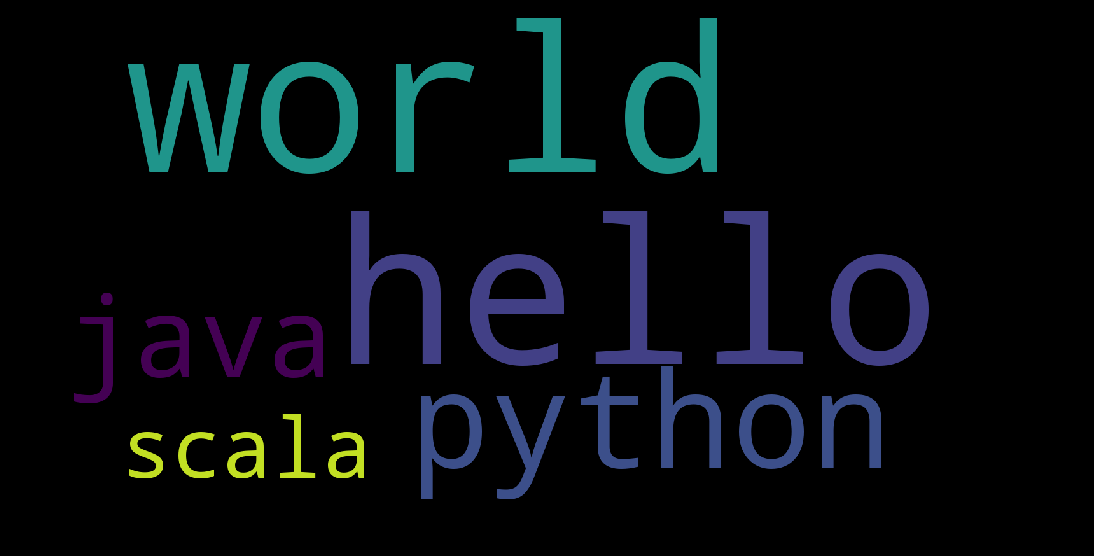

In [389]:
string = create_wordcloud(string)

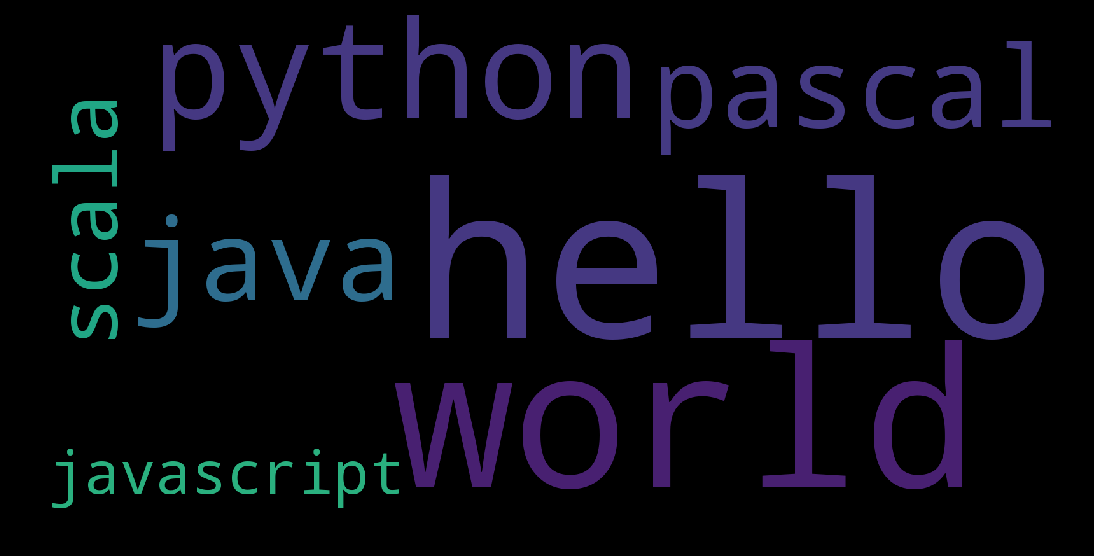

In [390]:
string += " pascal pascal javascript"
string = create_wordcloud(string)

In [ ]:
now = time.time()

profAnswer = "experiment melt chocolate"
profAnswer += ""
ref_w1q1, english_sim_scores = check_responses(ref_w1q1, 'text', 60, profAnswer)

print('It took {s} mins to run this method'.format(s=(time.time()-now)/60))

In [165]:
PROF_EXPECTATION = "experiment melt chocolate"
PROF_EXPECTATION += " somethings else"

LATENT_SPACE = 60

In [163]:
data_framee = pd.read_csv(PATH_TO_DATA)
data_framee.head()

text
0  The WISE simulations allowed the students to c...
1  The most effective aspects in wise activity we...
2  WISE uses predict-observe-explain patterns wit...
3  It appears that the interactive app allowed th...
4  Students can make predictions and test them. T...

In [171]:
data_framee, sim_scores = check_responses(data_framee, 'text', LATENT_SPACE, PROF_EXPECTATION)

There are 733 responses in 2041 significant terms


In [172]:
data_framee.head()

text  \
0  The WISE simulations allowed the students to c...   
1  The most effective aspects in wise activity we...   
2  WISE uses predict-observe-explain patterns wit...   
3  It appears that the interactive app allowed th...   
4  Students can make predictions and test them. T...   

                                   standardized_text  \
0  the wise simulations allowed the students to c...   
1  the most effective aspects in wise activity we...   
2  wise uses predict observe explain patterns wit...   
3  it appears that the interactive app allowed th...   
4  students can make predictions and test them. t...   

                                      processed_text  score  
0  wise simulation allow student conceptualize ab...    0.0  
1  effective aspect wise activity create spirit t...    0.0  
2  wise use predict observe explain pattern promp...    0.0  
3  appear interactive app allow visualize science...    0.0  
4    student make prediction test work small group      0.0